In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from  pathlib import Path


In [2]:
from segmentation_utils.dataloader import (
    ImageCircleDatasetV2,
    ImageCircleDatasetSeperate,
)

import numpy as np


/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
grade_timesteps = pd.read_csv("/home/tsakalis/ntua/phd/cellforge/cellforge/data/grade_timesteps.csv")

In [915]:
df = pd.read_excel("/home/tsakalis/ntua/phd/pronuclei_detector/data/whole_dna_tsakalis.xlsx")

In [916]:
df['Class_Grade'].dropna().value_counts()

Class_Grade
0.0    174
2.0     88
1.0     24
Name: count, dtype: int64

In [6]:
list(df.columns)

['Slide ID',
 'Patient ID',
 'Birth Year',
 'Patient Comments',
 'Well',
 'Age',
 'technique used ',
 'Decision',
 'DAY OF BIOPSY',
 'Indication_PGT',
 'DEVELOPMENT DAY 5',
 'NO OF MII OOCYTES ',
 'NO OF EMBRYOS TESTED',
 'PGT RESULT',
 'Class_Grade',
 'SUBGROUPS OF 0',
 'Transferred',
 'tPB2',
 'tPNa',
 'tPNf',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 'tSC',
 'tM',
 'tSB',
 'tB',
 'tEB',
 'tHB',
 'tDead',
 'Transferred.1',
 'Dynamic Score - Time',
 'Dynamic Score - Value',
 'Morphological Grade - Time',
 'Morphological Grade - Value',
 'Z Score - Time',
 'Z Score - Value',
 'Fragmentation - Time 1',
 'Fragmentation - Value 1',
 'Fragmentation - Time 2',
 'Fragmentation - Value 2',
 'Fragmentation - Time 3',
 'Fragmentation - Value 3',
 'Fragmentation - Time 4',
 'Fragmentation - Value 4',
 'Fragmentation - Time 5',
 'Fragmentation - Value 5',
 'Fragmentation - Time 6',
 'Fragmentation - Value 6',
 'Fragmentation - Time 7',
 'Fragmentation - Value 7',
 'Fragmentation - 

In [7]:

df['embryo_id'] = df['Slide ID'] + "_"+df['Well'].astype(str)

In [8]:
pth_lib = Path('/media/tsakalis/STORAGE/phd/raw_timelapses')
pth_lib2 = Path("/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses")

In [9]:
def get_slide_ids(pth: Path) -> list[str]:
    return [(x.name, x) for x in list(pth.glob('*'))]



In [10]:
file_avail = pd.DataFrame(get_slide_ids(pth_lib)+get_slide_ids(pth_lib2), columns=['embryo_id', 'pth']).drop_duplicates(subset=['embryo_id'])

In [11]:
file_avail

,embryo_id,pth
0,D2011.06.07_S0065_I149_1,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...
1,D2011.06.07_S0065_I149_2,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...
2,D2011.06.07_S0065_I149_3,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...
3,D2011.06.07_S0065_I149_4,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...
4,D2011.07.09_S0085_I149_1,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...
...,...,...
11214,D2018.11.16_S01901_I0149_D_1,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
11215,D2019.05.12_S01994_I0149_D_10,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
11216,D2016.11.12_S1429_I149_6,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
11217,D2018.05.22_S01811_I0149_D_7,/home/tsakalis/ntua/phd/cellforge/cellforge/da...


In [12]:
file_avail.sample(1)

,embryo_id,pth
6258,D2013.02.13_S0462_I149_1,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...


In [13]:
pd.merge(df, file_avail,how='inner', on='embryo_id')['Class_Grade'].dropna().value_counts()

Class_Grade
0.0    128
2.0     71
1.0     15
Name: count, dtype: int64

In [14]:
merged_df = pd.merge(df, file_avail,how='inner', on='embryo_id')

In [15]:
import sqlite3

def fetch_images(db_path: str, run_exclude: int = -1, focal_value: int = 0, well=1):
    """
    Connects to the SQLite database at db_path, reads from the IMAGES table,
    and returns all rows where Run != run_exclude and focal == focal_value.
    """
    conn = sqlite3.connect(db_path)
    conn.row_factory = sqlite3.Row  # optional: to get dict-like row objects
    cur = conn.cursor()
    sql = """
        SELECT *
        FROM IMAGES
        WHERE Run != ?
          AND focal = ?

          limit 4
    """
    cur.execute(sql, (run_exclude, focal_value))
    rows = cur.fetchall()
    conn.close()

    return rows


In [16]:
import os

In [17]:
merged_df['Slide ID'].nunique()

74

In [18]:
slide_pth = Path('/media/tsakalis/STORAGE/synology/SynologyDrive/slides')
slide_extra_pth = Path('/media/tsakalis/STORAGE/synology/SynologyDrive/extra_slides')

In [19]:
grade_timesteps_per_well = grade_timesteps.groupby('id').apply(lambda x: x.diff().iloc[1:].mean()).reset_index()

In [20]:
grade_timesteps_per_well

,id,dt
0,D2016.01.05_S1181_I149_10,0.006967
1,D2016.01.05_S1181_I149_3,0.006967
2,D2016.01.05_S1181_I149_5,0.006967
3,D2016.01.05_S1181_I149_6,0.006967
4,D2016.01.05_S1181_I149_7,0.006967
...,...,...
2327,D2019.05.29_S02006_I0149_D_2,0.010420
2328,D2019.05.29_S02006_I0149_D_4,0.010420
2329,D2019.05.29_S02006_I0149_D_5,0.010420
2330,D2019.05.29_S02006_I0149_D_7,0.010420


In [21]:
grade_timesteps_per_well['Slide ID'] = grade_timesteps_per_well.apply(lambda x: '_'.join(x['id'].split('_')[:-1]),axis=1)

In [22]:
grade_timesteps_per_well

,id,dt,Slide ID
0,D2016.01.05_S1181_I149_10,0.006967,D2016.01.05_S1181_I149
1,D2016.01.05_S1181_I149_3,0.006967,D2016.01.05_S1181_I149
2,D2016.01.05_S1181_I149_5,0.006967,D2016.01.05_S1181_I149
3,D2016.01.05_S1181_I149_6,0.006967,D2016.01.05_S1181_I149
4,D2016.01.05_S1181_I149_7,0.006967,D2016.01.05_S1181_I149
...,...,...,...
2327,D2019.05.29_S02006_I0149_D_2,0.010420,D2019.05.29_S02006_I0149_D
2328,D2019.05.29_S02006_I0149_D_4,0.010420,D2019.05.29_S02006_I0149_D
2329,D2019.05.29_S02006_I0149_D_5,0.010420,D2019.05.29_S02006_I0149_D
2330,D2019.05.29_S02006_I0149_D_7,0.010420,D2019.05.29_S02006_I0149_D


In [23]:
all_ = {}
for id_ in merged_df['Slide ID'].unique():
    if os.path.exists(slide_pth/f"{id_}.pdb"):
        images_ = fetch_images(slide_pth/f"{id_}.pdb")
    elif os.path.exists(slide_pth/f"{id_}.sqlite3"):
        images_ = fetch_images(slide_pth/f"{id_}.sqlite3")
    elif os.path.exists(slide_extra_pth/f"{id_}.sqlite3"):
        images_ = fetch_images(slide_extra_pth/f"{id_}.sqlite3")
    elif os.path.exists(slide_extra_pth/f"{id_}.pdb"):
        images_ = fetch_images(slide_extra_pth/f"{id_}.pdb")
    else:
        all_[id_] = grade_timesteps_per_well.loc[grade_timesteps_per_well['Slide ID']==id_]['dt'].mean()
        continue

    dt_ = images_[1]['Time']-images_[0]['Time']

    all_[id_] = dt_
    # break
    # try:
    #     images = fetch_images(slide_pth/f"{id_}.pdb")
    # except Exception as e:
    #     print(e)

In [24]:
os.path.exists(slide_extra_pth/f"{id_}.sqlite3")

False

(array([ 4.,  1., 60.,  5.,  2.,  0.,  1.,  0.,  0.,  1.]),
 array([0.00679204, 0.00851368, 0.01023532, 0.01195697, 0.01367861,
        0.01540025, 0.0171219 , 0.01884354, 0.02056519, 0.02228683,
        0.02400847]),
 <BarContainer object of 10 artists>)

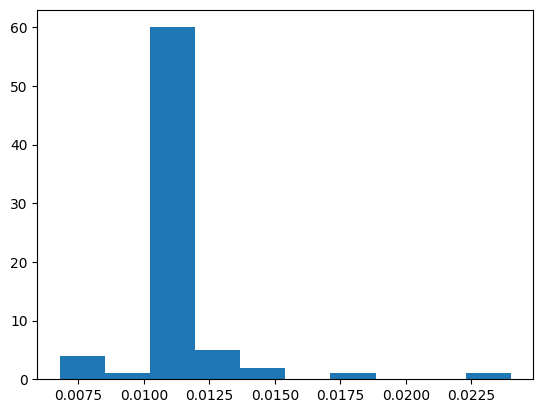

In [25]:
import matplotlib.pyplot as plt
plt.hist(all_.values())

In [26]:
target_column = 'PGT RESULT'

In [27]:
merged_df['y'] = merged_df['Class_Grade'].fillna(0)

In [28]:
# merged_df[['y']+[target_column]].to_csv('targets.csv',index=False)

In [29]:
weights_pth = Path('/home/tsakalis/Desktop/final_pn_weights/multilabel_dpt-vit_base_patch16_224.augreg_in21k_3_classes_SEPARATE_MASK_FINAL.pt')

weights_pth_separate_df = Path('/home/tsakalis/Desktop/final_pn_weights/multiclass_dpt-vit_base_patch16_224.augreg_in21k_4_classes_whole_mask_FINAL.pt')

weights_pth_whole = Path('/home/tsakalis/Desktop/final_pn_weights/multiclass_dpt-vit_base_patch16_224.augreg_in21k_3_classes_WHOLE_SINGLE_MASK_FINAL.pt')

In [30]:
import segmentation_models_pytorch as smp
from tqdm import tqdm
from PIL import Image
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
n_classes = 3
model_pronuclei = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )

model_pronuclei.load_state_dict(
        torch.load(
          weights_pth,
            weights_only=True,
        )
    )


model_pronuclei_whole = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )



model_name = "multiclass_dpt-vit_base_patch16_224.augreg_in21k_3_classes_WHOLE_SINGLE_MASK_FINAL"#"multiclass_u-mit_b5"
    # f"{type_of_problem}_{model_pronuclei.__dict__['name']}",
model_pronuclei_whole.load_state_dict(
    torch.load(
        f"/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/{model_name}.pt",
        weights_only=True,
    )
    )
model_pronuclei_separate = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=4,
    )

model_pronuclei_separate.load_state_dict(
        torch.load(
          weights_pth_separate_df,
            weights_only=True,
        )
    )


<All keys matched successfully>

In [31]:
torch.cuda.is_available()

True

In [651]:
device='cuda'
model_pronuclei_separate.to(device)

device='cuda'
model_pronuclei_whole.eval()
model_pronuclei_whole.to(device)

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [33]:
timesteps = Path('../../data/grade_timesteps.csv')

timesteps_df = pd.read_csv(timesteps)

In [34]:
timesteps_df.groupby('id').apply(lambda x: x.iloc[50:52].diff().iloc[1]).sort_values('dt').mean(
)

dt    0.009749
dtype: float64

In [35]:
from skimage.feature import graycomatrix, graycoprops


In [36]:
AVERAGE_TIMESTEP = 0.009 # hours/frame

In [37]:
import numpy as np
import cv2
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops

from scipy.stats import skew, kurtosis

AVERAGE_TIMESTEP = 1.0  # or whatever your dt is

def extract_shape_geometry_features(img: np.ndarray):
    """
    Given a 2D uint8 array (binary mask), threshold at >0, find connected components,
    and return a dict of geometric features for the largest (or only) blob:
      - centroid (row, col)
      - area
      - filled_area
      - perimeter
      - bbox (min_row, min_col, max_row, max_col)
      - bounding_box_area
      - extent (area / bounding_box_area)
      - aspect_ratio (width/height)
      - equivalent_diameter
      - major_axis_length
      - minor_axis_length
      - orientation (radians)
      - convex_area
      - convex_hull_coords (Nx2 array of (row, col))
      - convex_perimeter
      - solidity (area / convex_area)
      - eccentricity (from regionprops)
      - euler_number
      - extent (area / bbox_area)
      - circularity (4π·area / perimeter²)
      - feret_diameter_max (maximum caliper distance via convex hull)
      - hu_moments (7,)
      - skeleton_length (# of pixels in skeleton)
      - endpoints (# of skeleton endpoints)
      - dt (average timestep between frames)
    """
    # 1) Binarize & label
    binary = img > 0
    labeled = label(binary)
    props = regionprops(labeled)

    # If no blobs at all, return a dict full of Nones
    if not props:
        return {
            'centroid_row': None,
            'centroid_col': None,
            'area': None,
            'filled_area': None,
            'perimeter': None,
            'bbox': None,
            'bounding_box_area': None,
            'extent': None,
            'aspect_ratio': None,
            'equivalent_diameter': None,
            'major_axis_length': None,
            'minor_axis_length': None,
            'orientation': None,
            'convex_area': None,
            'convex_hull': None,
            'convex_perimeter': None,
            'solidity': None,
            'eccentricity': None,
            'euler_number': None,
            'circularity': None,
            'feret_diameter_max': None,
            'hu_moments': None,
            'skeleton_length': None,
            'endpoints': None,
            'dt': AVERAGE_TIMESTEP
        }

    # Find the largest region by area (in case of multiple small blobs)
    region = max(props, key=lambda r: r.area)

    # If the largest blob is too small, treat as "no meaningful region"
    if region.area < 5:
        return {
            'centroid_row': None,
            'centroid_col': None,
            'area': None,
            'filled_area': None,
            'perimeter': None,
            'bbox': None,
            'bounding_box_area': None,
            'extent': None,
            'aspect_ratio': None,
            'equivalent_diameter': None,
            'major_axis_length': None,
            'minor_axis_length': None,
            'orientation': None,
            'convex_area': None,
            'convex_hull': None,
            'convex_perimeter': None,
            'solidity': None,
            'eccentricity': None,
            'euler_number': None,
            'circularity': None,
            'feret_diameter_max': None,
            'hu_moments': None,
            'skeleton_length': None,
            'endpoints': None,
            'dt': AVERAGE_TIMESTEP
        }

    # Basic shape features from regionprops
    area = region.area
    filled_area = region.filled_area
    perimeter = region.perimeter
    minr, minc, maxr, maxc = region.bbox
    height = maxr - minr
    width = maxc - minc
    bbox_area = width * height if (width > 0 and height > 0) else np.nan
    extent = area / bbox_area if bbox_area and not np.isnan(bbox_area) else np.nan
    aspect_ratio = width / float(height) if height > 0 else np.nan
    equiv_diameter = region.equivalent_diameter
    major_axis_length = region.major_axis_length
    minor_axis_length = region.minor_axis_length
    orientation = region.orientation  # in radians
    convex_area = region.convex_area
    eccentricity = region.eccentricity
    solidity = region.solidity  # area / convex_area
    euler_number = region.euler_number

    # Circularity: 4*pi*area / (perimeter^2)
    circularity = (4 * np.pi * area / (perimeter ** 2)) if perimeter > 0 else np.nan

    # Convex hull coords via OpenCV (to compute convex perimeter and Feret diameter)
    mask = region.image.astype(np.uint8)  # region-local mask
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    hull = cv2.convexHull(cnts[0])
    hull_pts = hull.squeeze()
    # Convert to global coordinates
    hull_global = np.column_stack([
        hull_pts[:, 1] + minr,  # row
        hull_pts[:, 0] + minc   # col
    ])
    # Convex perimeter (length of hull contour)
    convex_perimeter = cv2.arcLength(hull, True)
    # Compute maximum caliper distance (Feret diameter) from hull points
    # Brute‐force: pairwise distances
    if hull_pts.ndim == 2 and hull_pts.shape[0] > 1:
        # hull_pts are local coords [ [col, row], … ]
        pts = hull_pts[:, ::-1]  # convert to (row, col) if needed, but distances same regardless of ordering
        dists = np.sqrt(((pts[:, None, :] - pts[None, :, :]) ** 2).sum(axis=2))
        feret_diameter_max = np.nanmax(dists)
    else:
        feret_diameter_max = 0.0

    # Hu moments
    m = cv2.moments(mask)
    hu = cv2.HuMoments(m).flatten()

    # Skeletonize to compute skeleton length and endpoints
    from skimage.morphology import skeletonize, medial_axis
    from scipy import ndimage as ndi

    # skeleton (binary) of the region
    skeleton = skeletonize(mask > 0)
    skeleton_length = np.count_nonzero(skeleton)

    # Count endpoints: pixels in skeleton with only one neighbor
    # Compute neighbor count via convolution
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])
    neighbor_map = ndi.convolve(skeleton.astype(np.uint8), np.ones((3, 3)), mode='constant', cval=0)
    # For each skeleton pixel, count adjacent skeleton pixels
    endpoints = 0
    for (r, c), val in np.ndenumerate(skeleton):
        if val:
            # Count neighbors in 8‐connectivity
            nbr_count = np.sum(skeleton[max(r-1, 0):r+2, max(c-1, 0):c+2]) - 1
            if nbr_count == 1:
                endpoints += 1

    return {
        'centroid_row': float(region.centroid[0]),
        'centroid_col': float(region.centroid[1]),
        'area': area,
        'filled_area': filled_area,
        'perimeter': perimeter,
        'bbox': (minr, minc, maxr, maxc),
        'bounding_box_area': bbox_area,
        'extent': extent,
        'aspect_ratio': aspect_ratio,
        'equivalent_diameter': equiv_diameter,
        'major_axis_length': major_axis_length,
        'minor_axis_length': minor_axis_length,
        'orientation': orientation,
        'convex_area': convex_area,
        'convex_hull': hull_global,        # Nx2 array of (row, col)
        'convex_perimeter': convex_perimeter,
        'solidity': solidity,
        'eccentricity': eccentricity,
        'euler_number': euler_number,
        'circularity': circularity,
        'feret_diameter_max': feret_diameter_max,
        'hu_moments': hu,                  # length-7 array
        'skeleton_length': skeleton_length,
        'endpoints': endpoints,
        'dt': AVERAGE_TIMESTEP
    }


def extract_intensity_features(gray_img: np.ndarray, mask: np.ndarray, distances=[1], angles=[0]):
    """
    Given a 2D grayscale image and a binary mask (same dimensions), compute
    intensity-based features over the region where mask>0. Returns:
      - mean_intensity
      - median_intensity
      - std_intensity
      - min_intensity
      - max_intensity
      - skewness
      - kurtosis
      - entropy (Shannon)
      - percentiles (10th, 25th, 75th, 90th)
      - GLCM texture features: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        (averaged over specified distances and angles)
      - dt (not meaningful here, but kept for consistency)
    """
    # Extract pixel values under mask
    pixels = gray_img[mask > 0].ravel().astype(np.float64)
    if pixels.size == 0:
        return {
            'mean_intensity': None,
            'median_intensity': None,
            'std_intensity': None,
            'min_intensity': None,
            'max_intensity': None,
            'skewness': None,
            'kurtosis': None,
            'entropy': None,
            'percentile_10': None,
            'percentile_25': None,
            'percentile_75': None,
            'percentile_90': None,
            'glcm_contrast': None,
            'glcm_dissimilarity': None,
            'glcm_homogeneity': None,
            'glcm_ASM': None,
            'glcm_energy': None,
            'glcm_correlation': None,
            'dt': None
        }

    # Basic statistics
    mean_intensity = float(np.mean(pixels))
    median_intensity = float(np.median(pixels))
    std_intensity = float(np.std(pixels))
    min_intensity = float(np.min(pixels))
    max_intensity = float(np.max(pixels))
    skewness = float(skew(pixels))
    kurt = float(kurtosis(pixels))

    # Shannon entropy over pixel histogram (256 bins)
    hist, _ = np.histogram(pixels, bins=256, range=(0, 255), density=True)
    # avoid log(0) by masking
    hist_nonzero = hist[hist > 0]
    entropy = float(-np.sum(hist_nonzero * np.log2(hist_nonzero)))

    # Percentiles
    p10 = float(np.percentile(pixels, 10))
    p25 = float(np.percentile(pixels, 25))
    p75 = float(np.percentile(pixels, 75))
    p90 = float(np.percentile(pixels, 90))

    # GLCM texture features: compute on masked region by cropping to bounding box
    coords = np.column_stack(np.where(mask > 0))
    minr, minc = coords.min(axis=0)
    maxr, maxc = coords.max(axis=0)
    roi = gray_img[minr:maxr+1, minc:maxc+1]
    roi_mask = mask[minr:maxr+1, minc:maxc+1]

    # Quantize ROI to 8 gray levels (0–7)
    roi_quant = np.floor(roi / 32).astype(np.uint8)
    roi_quant[roi_mask == 0] = 0  # force background to zero

    glcm = graycomatrix(
        roi_quant,
        distances=distances,
        angles=angles,
        levels=8,
        symmetric=True,
        normed=True
    )

    contrast = float(np.mean(graycoprops(glcm, 'contrast')))
    dissimilarity = float(np.mean(graycoprops(glcm, 'dissimilarity')))
    homogeneity = float(np.mean(graycoprops(glcm, 'homogeneity')))
    ASM = float(np.mean(graycoprops(glcm, 'ASM')))
    energy = float(np.mean(graycoprops(glcm, 'energy')))
    correlation = float(np.mean(graycoprops(glcm, 'correlation')))

    return {
        'mean_intensity': mean_intensity,
        'median_intensity': median_intensity,
        'std_intensity': std_intensity,
        'min_intensity': min_intensity,
        'max_intensity': max_intensity,
        'skewness': skewness,
        'kurtosis': kurt,
        'entropy': entropy,
        'percentile_10': p10,
        'percentile_25': p25,
        'percentile_75': p75,
        'percentile_90': p90,
        'glcm_contrast': contrast,
        'glcm_dissimilarity': dissimilarity,
        'glcm_homogeneity': homogeneity,
        'glcm_ASM': ASM,
        'glcm_energy': energy,
        'glcm_correlation': correlation,
        'dt': AVERAGE_TIMESTEP
    }


In [669]:
from typing import Any
def inference_whole_slide(model, slide_pth: Path, max_frame: int, whole_model: Any| None = None):

    image_file_paths = sorted(list(slide_pth.glob("*.jpg")), key=lambda x: int(x.stem))[
        :max_frame
    ]

    images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

    val_dataset = ImageCircleDatasetV2(images, images, images, images, predict=True)

    val_dataloader = DataLoader(val_dataset, batch_size=32)

    model.eval()
    from torch.cuda.amp import autocast

    all_masks = []


    all_whole_masks = []
    for inpt_images, _ in val_dataloader:
        with torch.no_grad():
            # with autocast():

            pred_mask = model(inpt_images.to(device))
            #
            # masks = torch.softmax(pred_mask,axis=1).cpu().numpy()>0.05
            
            masks = torch.sigmoid(pred_mask).cpu().numpy()

            if whole_model:
                pred_mask = whole_model(inpt_images.to(device))
                mask_whole = torch.softmax(pred_mask,axis=1).cpu().numpy()[:,1,:,:]
                all_whole_masks.extend([msk for msk in mask_whole])
                # masks[...,0]+masks_whole

            
            all_masks.extend([msk for msk in masks])
            # breakpoint()

    pn_size = []
    final_images = []
    upscaled_masks = []
    isolated_pns = []
    counter = 0
    for pil_img, mask in zip(images[:], all_masks[:]):
        # Ensure the mask is 2D by removing extra dimensions
        # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
        if len(all_whole_masks)>0:
            whole_mask = all_whole_masks[counter]
            pn_mask_1 = ((mask[0]+whole_mask)/2)>0.8
            pn_mask_2 = ((mask[1]+whole_mask)/2)>0.8
        else:
            whole_mask = mask[0]

            pn_mask_1 = mask[0]

            pn_mask_2 = mask[1]

        image_ar = np.stack(3 * [np.array(pil_img)])


        

        # upscaled_mask1 = cv2.resize(
        #     pn_mask_1.astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        # )
        # upscaled_mask2 = cv2.resize(
        #     pn_mask_2.astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        # )
        upscaled_mask3 = cv2.resize(
            mask[2].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )

        # pn_size.append(upscaled_mask.sum())

        upscaled_masks.append((pn_mask_1, pn_mask_2, upscaled_mask3))
        image_pn_isolated = image_ar.copy()
        # image_pn_isolated[:, ~upscaled_mask1.astype(bool)] = 0
        # isolated_pns.append(image_pn_isolated.transpose(1, 2, 0))
        # image_ar[0, upscaled_mask1.astype(bool)] = 1
        # image_ar[1, upscaled_mask2.astype(bool)] = 1
        # image_ar[2, upscaled_mask3.astype(bool)] = 1

        final_images.append(Image.fromarray(image_ar.transpose(1, 2, 0)))
        counter+=1

    return (
        final_images,
        
        upscaled_masks,
    )


In [670]:
weird_slides =[ "D2018.05.02_S01786_I0149_D_4"]

In [671]:
paper_paths = [
    #Path("/media/tsakalis/STORAGE/phd/raw_timelapses/D2018.11.20_S01902_I0149_D_2"),
# pth_lib/"D2017.02.07_S1493_I149_12",
# pth_lib/"D2017.02.07_S1493_I149_11"
# pth_lib/"D2017.01.24_S1480_I149_1"
pth_lib/"D2017.01.17_S1472_I149_2"
]

In [672]:

pn1_features_all =[]
pn2_features_all = []

# pn1_features_intens =[]
# pn2_features_intens = []
whole_emb_all = []
for slide_path in paper_paths:


    images, masks = inference_whole_slide(model_pronuclei,slide_path,130)
    pn1_features = pd.DataFrame([extract_shape_geometry_features(msk[0]) for msk in masks])
    pn2_features = pd.DataFrame([extract_shape_geometry_features(msk[1]) for msk in masks])

    # pn1_intensity_features = pd.DataFrame([extract_intensity_features(np.array(img)[...,0], msk[0]) for img, msk in zip(images,masks)])
    # pn2_intensity_features = pd.DataFrame([extract_intensity_features(np.array(img)[...,0], msk[1]) for img, msk in zip(images,masks)])
    
    whole_emb = pd.DataFrame([extract_shape_geometry_features(msk[2]) for msk in masks])

    pn1_features['embryo_id'] = slide_path.name
    pn2_features['embryo_id'] = slide_path.name
    whole_emb['embryo_id'] = slide_path.name

    # pn1_intensity_features['embryo_id'] = slide_path.name

    # pn2_intensity_features['embryo_id'] = slide_path.name
    
    pn1_features_all.append(pn1_features)
    pn2_features_all.append(pn2_features)

    # pn1_features_intens.append(pn1_intensity_features)
    # pn2_features_intens.append(pn2_intensity_features)


    whole_emb_all.append(whole_emb)
    # break





100%|██████████| 130/130 [00:00<00:00, 70620.32it/s]


(array([    0.,     0.,     0.,     0.,     0., 50176.,     0.,     0.,
            0.,     0.]),
 array([-0.5       , -0.40000001, -0.30000001, -0.2       , -0.1       ,
         0.        ,  0.1       ,  0.2       ,  0.30000001,  0.40000001,
         0.5       ]),
 <BarContainer object of 10 artists>)

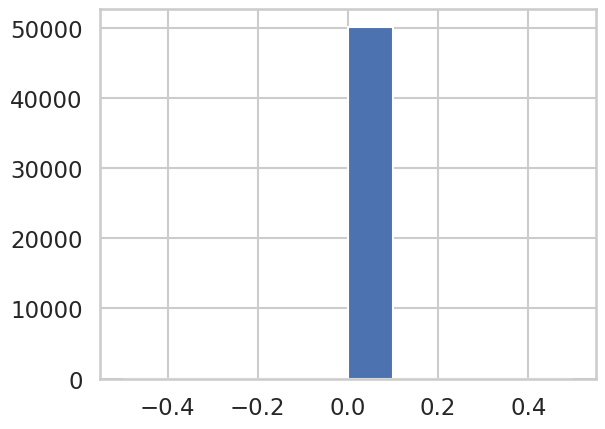

In [676]:
plt.hist(masks[96][0].flatten())

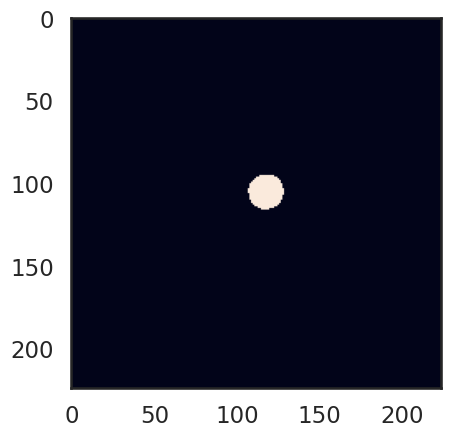

In [918]:
plt.imshow(masks[45][0])

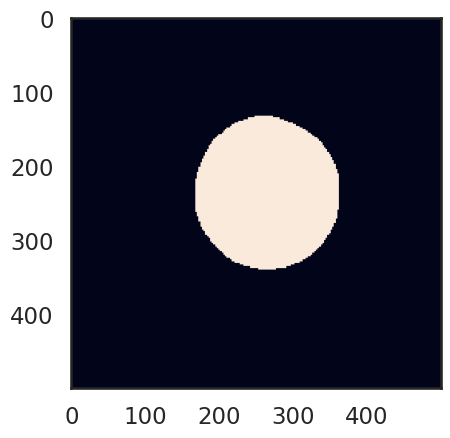

In [921]:
plt.imshow(masks[45][2])

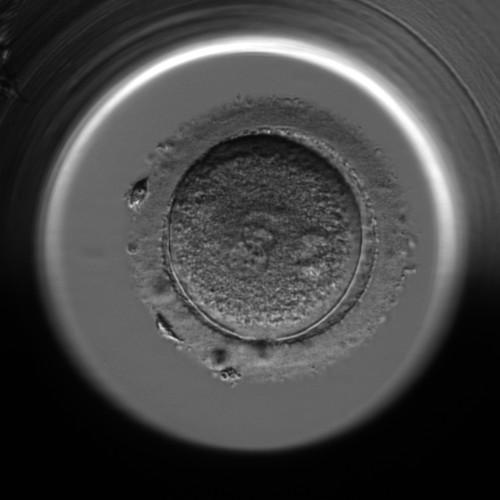

In [919]:
images[45]

In [619]:
pn2_features_all[0]['area'].values

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
       233.,  nan,  nan,  nan, 314.,  nan, 206., 318.,  nan, 275., 342.,
       337., 405., 343., 335., 367., 391., 379., 410., 387., 388., 404.,
       379., 377., 400., 397., 402., 374., 397., 421., 409., 373., 416.,
       431., 393., 395., 408., 420., 421., 387., 407., 419., 412., 433.,
       416., 410., 429., 419., 428., 418., 422., 415., 426., 414., 386.,
       401., 407., 459., 425., 435., 443., 438., 451., 452., 420., 431.,
       429., 479., 450., 435., 443., 455., 418., 429., 444., 442., 464.,
       432., 305., 304., 250., 131., 137., 188., 235., 330., 214., 290.,
       284., 172., 193.,  nan, 104.,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

<Axes: >

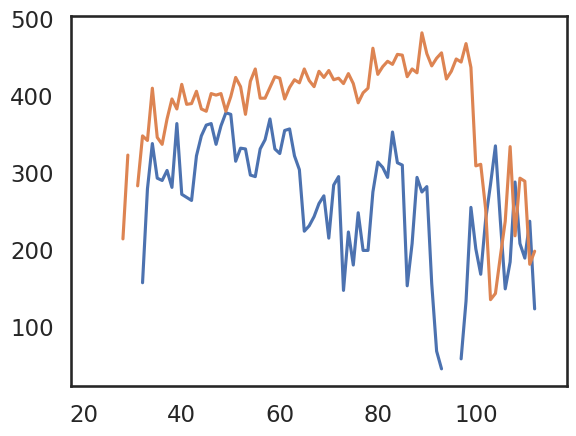

In [920]:
pn1_features_all[0]['area'].plot()
pn2_features_all[0]['area'].plot()

In [441]:
full_pn1_df = pd.concat(pn1_features_all).reset_index()
full_pn2_df = pd.concat(pn2_features_all).reset_index()






whole_emb_all_df = pd.concat(whole_emb_all).reset_index()

full_pn1_df['Slide ID'] = full_pn1_df.apply(lambda x: '_'.join(x['embryo_id'].split('_')[:-1]),axis=1).values
full_pn2_df['Slide ID'] = full_pn2_df.apply(lambda x: '_'.join(x['embryo_id'].split('_')[:-1]),axis=1).values
whole_emb_all_df['Slide ID'] = whole_emb_all_df.apply(lambda x: '_'.join(x['embryo_id'].split('_')[:-1]),axis=1).values


full_pn1_df['dt_actual'] = full_pn1_df["Slide ID"].map(all_)
full_pn2_df['dt_actual'] = full_pn2_df["Slide ID"].map(all_)
whole_emb_all_df['dt_actual'] = whole_emb_all_df["Slide ID"].map(all_)

full_pn1_df['time_real'] = full_pn1_df['dt_actual'].cumsum()
full_pn2_df['time_real'] = full_pn2_df['dt_actual'].cumsum()

whole_emb_all_df['time_real'] = whole_emb_all_df['dt_actual'].cumsum()

In [442]:
full_pn1_df['time_real'] = full_pn1_df.groupby('embryo_id')['dt_actual'].cumsum()
full_pn2_df['time_real'] = full_pn2_df.groupby('embryo_id')['dt_actual'].cumsum()

# full_pn1_intens_df['time_real'] = full_pn1_intens_df.groupby('embryo_id')['dt'].cumsum()
# full_pn2_intens_df['time_real'] = full_pn2_intens_df.groupby('embryo_id')['dt'].cumsum()

whole_emb_all_df['time_real'] = whole_emb_all_df.groupby('embryo_id')['dt_actual'].cumsum()


In [43]:
full_pn1_df['dt_actual'] 

0      0.010448
1      0.010448
2      0.010448
3      0.010448
4      0.010448
         ...   
125    0.010448
126    0.010448
127    0.010448
128    0.010448
129    0.010448
Name: dt_actual, Length: 130, dtype: float64

In [705]:
full_pn1_df['time'] = full_pn1_df.groupby('embryo_id')['dt'].cumsum()
full_pn2_df['time'] = full_pn2_df.groupby('embryo_id')['dt'].cumsum()


whole_emb_all_df['time'] = whole_emb_all_df.groupby('embryo_id')['dt'].cumsum()


In [706]:
# full_pn1_df.to_parquet('full_pn1_df.parquet')

# full_pn2_df.to_parquet('full_pn2_df.parquet')

# whole_emb_all_df.to_parquet('full_emb_df.parquet')

In [707]:
full_pn1_df = pd.read_parquet('full_pn1_df.parquet')

full_pn2_df = pd.read_parquet('full_pn2_df.parquet')


whole_emb_all_df = pd.read_parquet('full_emb_df.parquet')

In [708]:
whole_emb_all_df['embryo_id'].nunique()

218

In [709]:
simple_features = ['area', 'perimeter', 'eccentricity', 'solidity']

<Axes: >

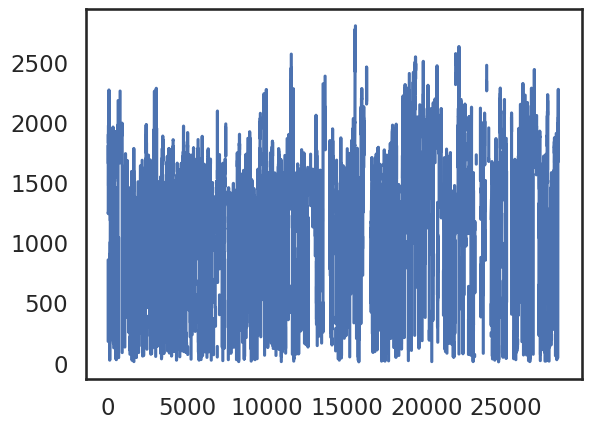

In [710]:
full_pn1_df['area'].apply(lambda x: np.mean(x)).plot()

<Axes: >

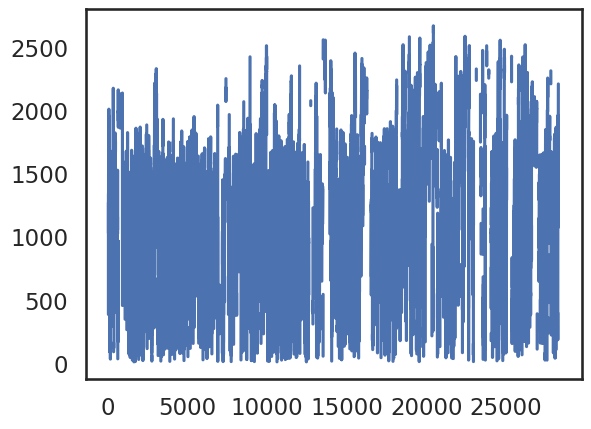

In [711]:
full_pn2_df['area'].apply(lambda x: np.mean(x)).plot()

In [712]:

def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [713]:
import numpy as np

def find_continuous_region(signal):
    nonzero_indices = np.nonzero(signal)[0]
    if nonzero_indices.size == 0:
        return None  # No non-zero region found
    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1]
    return start_idx, end_idx


In [714]:
import matplotlib.pyplot as plt

In [715]:
from scipy import signal

In [716]:
import numpy as np
def crosscorr(s1, s2):
    s1 = s1 - np.mean(s1)
    s2 = s2 - np.mean(s2)
    corr = np.correlate(s1, s2, mode='full')
    lag = np.argmax(corr) - (len(s2) - 1)
    max_corr = np.max(corr) / (np.std(s1) * np.std(s2) * len(s1))
    return max_corr, lag

In [717]:
AVERAGE_TIMESTEP = 0.009

In [718]:
full_pn1_df['embryo_id'].nunique()

218

In [719]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, kurtosis

# ---- helper functions ----
def find_signal(mask: np.ndarray):
    """Return (start_idx, length) of the longest contiguous True stretch in *mask*."""
    best_start = 0
    best_len = 0
    cur_start = None
    cur_len = 0
    for idx, flag in enumerate(mask):
        if flag:
            if cur_start is None:
                cur_start = idx
                cur_len = 1
            else:
                cur_len += 1
            if cur_len > best_len:
                best_start = cur_start
                best_len = cur_len
        else:
            cur_start = None
            cur_len = 0
    return best_start, best_len

def smooth_signal(x, window=20):
    """Simple centered moving average (min_periods=1)."""
    return pd.Series(x).rolling(window, center=True, min_periods=1).mean().values

# ---- config ----

In [720]:
# ---- main loop ----
for embryo_id in merged_df.dropna(subset=["Class_Grade"])["embryo_id"]:

    g1 = full_pn1_df[full_pn1_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)

    g1["area"] = g1["area"].fillna(1)
    start1, len1 = find_signal(g1["area"].values != 1)
    pn1 = g1.iloc[start1 : start1 + len1].reset_index(drop=True)

    g2 = full_pn2_df[full_pn2_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)
    start2, len2 = find_signal(g2["area"].values != 1)
    pn2 = g2.iloc[start2 : start2 + len2].reset_index(drop=True)

    if pn1.empty or pn2.empty:
        continue

    # label larger vs smaller PN
    if pn1["area"].max() < pn2["area"].max():
        first_pn, second_pn = pn2, pn1
        first_start, first_len = start2, len2
        second_start, second_len = start1, len1
    else:
        first_pn, second_pn = pn1, pn2
        first_start, first_len = start1, len1
        second_start, second_len = start2, len2

    whole_emb = whole_emb_all_df[whole_emb_all_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)

    whole_emb_slice1 = whole_emb.iloc[first_start : first_start + first_len].reset_index(drop=True)
    whole_emb_slice2 = whole_emb.iloc[second_start : second_start + second_len].reset_index(drop=True)

    if pn1.empty or pn2.empty:
        continue

    # label larger vs smaller PN
    if pn1["area"].max() < pn2["area"].max():
        first_pn, second_pn = pn2, pn1
        first_start, first_len = start2, len2
        second_start, second_len = start1, len1
    else:
        first_pn, second_pn = pn1, pn2
        first_start, first_len = start1, len1
        second_start, second_len = start2, len2

    break

In [721]:
non_correl_to_area = ["extent",	"aspect_ratio", "circularity", "solidity", "endpoints"]

In [722]:
df_pn1 = first_pn[["time_real","centroid_col","centroid_row","area"]]\
                 .rename(columns={"centroid_col":"x1","centroid_row":"y1","area":"area1"})
df_pn2 = second_pn[["time_real","centroid_col","centroid_row","area"]]\
            .rename(columns={"centroid_col":"x2","centroid_row":"y2","area":"area2"})
ov = pd.merge(df_pn1, df_pn2, on="time_real")
if not ov.empty:
    pdists = np.hypot(ov["x1"]-ov["x2"], ov["y1"]-ov["y2"])

In [723]:
pdists = np.hypot(ov["x1"]-ov["x2"], ov["y1"]-ov["y2"])

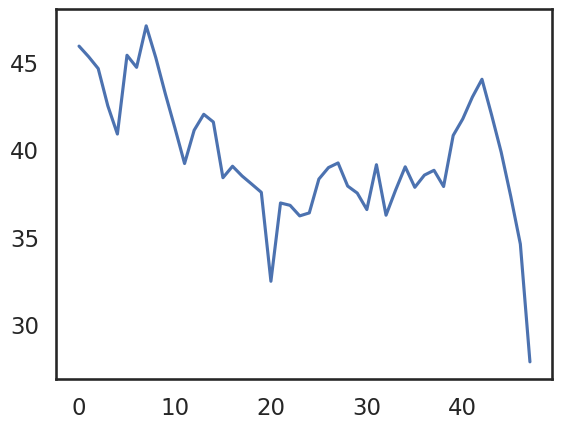

In [724]:
plt.plot(pdists)

In [725]:
full_pn1_df.columns

Index(['index', 'centroid_row', 'centroid_col', 'area', 'filled_area',
       'perimeter', 'bbox', 'bounding_box_area', 'extent', 'aspect_ratio',
       'equivalent_diameter', 'major_axis_length', 'minor_axis_length',
       'orientation', 'convex_area', 'convex_perimeter', 'solidity',
       'eccentricity', 'euler_number', 'circularity', 'feret_diameter_max',
       'hu_moments', 'skeleton_length', 'endpoints', 'dt', 'embryo_id',
       'Slide ID', 'dt_actual', 'time_real', 'time'],
      dtype='object')

### 3.1 Asynchrony

Asynchrony assesses whether the two pronuclei (PN1 and PN2) appear and disappear simultaneously or asynchronously.  
This measure captures temporal coordination during pronuclear development.

We defined asynchrony in appearance (`Aapp`) and disappearance (`Adis`) as follows:

- **Aapp** = |t<sub>PN1,app</sub> − t<sub>PN2,app</sub>|
- **Adis** = |t<sub>PN1,dis</sub> − t<sub>PN2,dis</sub>|

Where:

- t<sub>PN1,app</sub> and t<sub>PN2,app</sub> are the first time points at which each pronucleus becomes visible.
- t<sub>PN1,dis</sub> and t<sub>PN2,dis</sub> are the last time points at which each pronucleus is visible.

Higher values indicate increased asynchrony.

---

### 3.2 Distance Between Pronuclei

The distance between the two pronuclei indicates their spatial separation within the zygote. Pronuclear proximity may relate to successful syngamy and embryo viability.

The distance between pronuclei (`DPN`) at each frame is calculated using their centroids:

DPN(t) = √[(x<sub>PN1,t</sub> − x<sub>PN2,t</sub>)² + (y<sub>PN1,t</sub> − y<sub>PN2,t</sub>)²]




Where:

- (x<sub>PN1,t</sub>, y<sub>PN1,t</sub>) and (x<sub>PN2,t</sub>, y<sub>PN2,t</sub>) are the coordinates of the centroids of each pronucleus at time `t`.

We summarized the temporal distribution using mean, minimum, and maximum distances.

---

### 3.3 Eccentricity (PN Position Relative to Embryo Center)

Eccentricity quantifies how far each pronucleus deviates from the embryo’s geometric center. Pronuclei located closer to the center may indicate more typical developmental behavior.

We define the eccentricity of each pronucleus (`EPN`) as the distance between the pronuclear centroid and the embryo center normalized by embryo radius:

EPN(t) = √[(x<sub>PN,t</sub> − x<sub>emb</sub>)² + (y<sub>PN,t</sub> − y<sub>emb</sub>)²] / r<sub>emb</sub>


Where:

- (x<sub>emb</sub>, y<sub>emb</sub>) is the embryo center calculated from the embryo mask.
- r<sub>emb</sub> is the radius approximating embryo size.

We computed eccentricity separately for PN1 and PN2 and summarized it by average and peak eccentricity.

---

### 3.4 Visible Time (PN Visibility Duration)

The duration during which pronuclei are visible reflects the length of the pronuclear stage.

We define visibility duration (`Tvis`) as:

Tvis = t<sub>last dis</sub> − t<sub>first app</sub>

Where:

- t<sub>first app</sub> is the time the first pronucleus appears.
- t<sub>last dis</sub> is the time the last pronucleus disappears.

Duration is reported in hours (frame interval multiplied by the number of frames).

---

### 3.5 Movement Speed (Pronuclear Mobility)

Movement speed captures how fast each pronucleus moves within the embryo, potentially reflecting cytoskeletal dynamics and cytoplasmic conditions.

The instantaneous speed of each pronucleus (`VPN`) between consecutive frames is calculated as:

VPN(t) = √[(x<sub>PN,t</sub> − x<sub>PN,t−1</sub>)² + (y<sub>PN,t</sub> − y<sub>PN,t−1</sub>)²] / Δt

Where:

- Δt is the time between consecutive frames (approximately 13 minutes).

We summarize pronuclear speed using mean, median, and maximum speed over the visibility duration.

---

These detailed quantitative descriptors of pronuclear behavior facilitate a comprehensive analysis of their relationship to embryo chromosomal status and developmental potential.




In [726]:
 merged_df.dropna(subset=["Class_Grade"])["embryo_id"]

0           D2017.06.02_S1566_I149_2
1       D2017.11.22_S01667_I0149_D_2
2       D2017.11.22_S01667_I0149_D_6
3       D2017.11.22_S01667_I0149_D_8
4       D2017.11.22_S01667_I0149_D_3
                   ...              
209    D2017.10.25_S01641_I0149_D_10
210    D2017.10.25_S01641_I0149_D_11
211     D2018.01.27_S01708_I0149_D_5
212     D2018.02.13_S01720_I0149_D_1
213     D2018.02.13_S01720_I0149_D_5
Name: embryo_id, Length: 214, dtype: object

In [727]:
g1.dropna().shape[0]

53

(0.0, 1.25)

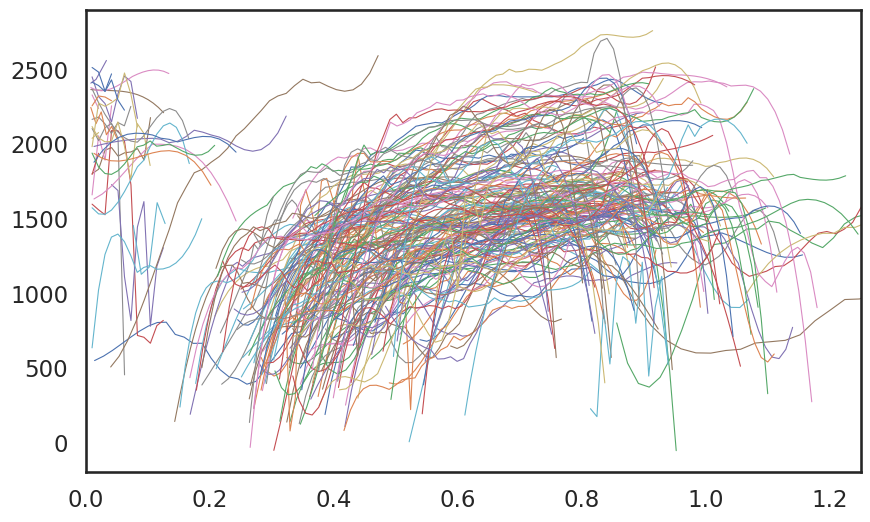

In [ ]:
import scipy
smooth_cols = [
    "area", "extent", "aspect_ratio",
    "circularity", "solidity", "endpoints",
    "centroid_col", "centroid_row"
]
non_correl_to_area = ["extent", "aspect_ratio", "circularity", "solidity", "endpoints"]

colors = {0:'red', 1: 'orange', 2: 'green'}
records = []
plt.figure(figsize=(10, 6))

all_metrics = []
# ---- main loop ----
for embryo_id in merged_df.dropna(subset=["Class_Grade"])["embryo_id"].unique():
    
    emb_metrics = {"embryo_id": embryo_id}
 
    g1 = full_pn1_df[full_pn1_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)

    if g1.dropna(subset=['area']).shape[0]==0:
        
        # if g1.dropna().shape[0]<1:
        # #     continue
        emb_metrics['visibility']= 0
        emb_metrics['target'] = merged_df.loc[merged_df['embryo_id']==embryo_id]['y'].values[0]
        all_metrics.append(emb_metrics)

        continue
      
            
    FILLER_VALUE = 1
            
    g1["area"] = g1["area"].fillna(FILLER_VALUE)
    start1, len1 = find_signal(g1["area"].values != FILLER_VALUE)
    pn1 = g1.iloc[start1 : start1 + len1].reset_index(drop=True)


    # --- PN2 group & smoothing ---
    g2 = full_pn2_df[full_pn2_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)

    g2["area"] = g2["area"].fillna(FILLER_VALUE)
    start2, len2 = find_signal(g2["area"].values != FILLER_VALUE)
    pn2 = g2.iloc[start2 : start2 + len2].reset_index(drop=True)

    # skip if missing
    if pn1.empty or pn2.empty:
        continue

    if g1['area'].max()<500 and (g2['area'].max()<500):
        
        # if g1.dropna().shape[0]<1:
        # #     continue
        emb_metrics['visibility']= 0
        emb_metrics['target'] = merged_df.loc[merged_df['embryo_id']==embryo_id]['y'].values[0]
        all_metrics.append(emb_metrics)

        continue
    # label larger vs smaller PN
    if pn1["area"].max() < pn2["area"].max():
        first_pn, second_pn = pn2, pn1
        first_start, first_len = start2, len2
        second_start, second_len = start1, len1
    else:
        first_pn, second_pn = pn1, pn2
        first_start, first_len = start1, len1
        second_start, second_len = start2, len2

    # --- whole-embryo track & smoothing ---
    whole_emb = whole_emb_all_df[whole_emb_all_df["embryo_id"] == embryo_id].copy()#.reset_index(drop=True)

    

    # ASYNCHRONY

    t1_appear = first_pn['time_real'].min()

    t2_appear = second_pn['time_real'].min()


    t1_fade = first_pn['time_real'].max()
    t2_fade = second_pn['time_real'].max()

    async_appear = t2_appear-t1_appear
    async_fade = t2_fade-t1_fade


    emb_metrics["async_appear"] =  async_appear
    emb_metrics["async_fade"] =  async_fade
    #

    # DISTANCE BETWEEN PRONUCLEI

    if (async_appear==0) and (async_fade==0):
        dy = (first_pn['centroid_col'].values-second_pn['centroid_col'].values)**2
        dx = (first_pn['centroid_row'].values-second_pn['centroid_row'].values)**2
        DPN = np.sqrt(dx+dy)



        emb_metrics["max_pn_dist"] = np.quantile(DPN,0.75)

        emb_metrics["min_pn_dist"] = np.quantile(DPN,0.5)

    else:

        common_idxs = [idx for idx  in first_pn['index'].tolist() if idx in second_pn['index'].tolist()]

        if len(common_idxs)==0:

            emb_metrics["max_pn_dist"] = np.nan

            emb_metrics["min_pn_dist"] = np.nan
        else:

            second_pn_aligned = second_pn.loc[second_pn['index'].isin(common_idxs)]
            first_pn_aligned = first_pn.loc[first_pn['index'].isin(common_idxs)]
            dy = (first_pn_aligned['centroid_col'].values-second_pn_aligned['centroid_col'].values)**2
            dx = (first_pn_aligned['centroid_row'].values-second_pn_aligned['centroid_row'].values)**2
            DPN = np.sqrt(dx+dy)



            emb_metrics["max_pn_dist"] = np.quantile(DPN,0.95)

            emb_metrics["min_pn_dist"] = np.quantile(DPN,0.05)
    
    # DISTANCE FROM EMBRYO
    # try:
    whole_emb_pn1_alignment = whole_emb.iloc[first_start:first_start+first_len].copy()

    dy = (first_pn['centroid_col'].values-whole_emb_pn1_alignment['centroid_col'].values)**2
    dx = (first_pn['centroid_row'].values-whole_emb_pn1_alignment['centroid_row'].values)**2
    DPE = np.sqrt(dx+dy)
    emb_metrics["max_emb_dist"] =np.quantile(DPE,0.95)

    emb_metrics["min_emb_dist"] =np.quantile(DPE,0.05)
    # except Exception as e:
    #     print(e)
    #     whole_emb_pn1_alignment = whole_emb.iloc[start1:start1+len1].copy()

    #     dy = (first_pn['centroid_col'].values-whole_emb_pn1_alignment['centroid_col'].values)**2
    #     dx = (first_pn['centroid_row'].values-whole_emb_pn1_alignment['centroid_row'].values)**2

    #     DPE = np.sqrt(dx+dy)
    #     emb_metrics["max_emb_dist"] =np.quantile(DPE,0.75)

    #     emb_metrics["min_emb_dist"] =np.quantile(DPE,0.05)
      
    #     continue


    # VISIBILITY

    noise = 0
    # if t1_appear<0.011:
    #     noise = np.random.normal(0.1,0.01)
    
    emb_metrics["visibility"] = t1_fade-t1_appear


    # #SPEED
    # dt = first_pn['time_real'].iloc[1]-first_pn['time_real'].iloc[0]
    # VSP =  np.sqrt((first_pn['centroid_col'].diff())**2+(first_pn['centroid_row'].diff())**2)/dt

    # emb_metrics['speed'] = np.quantile(VSP.dropna().values, 0.95)

    emb_metrics['area_max'] = first_pn['area'].max()
    emb_metrics['target'] = merged_df.loc[merged_df['embryo_id']==embryo_id]['y'].values[0]


    all_metrics.append(emb_metrics)

    SG_WINDOW = 15  # must be odd
    SG_POLYORDER = 3
    EMA_SPAN   = 12
    try:
        area_sg = scipy.signal.savgol_filter(first_pn['area'], SG_WINDOW, SG_POLYORDER)
        area_sg2 = scipy.signal.savgol_filter(second_pn['area'], SG_WINDOW, SG_POLYORDER)
    except Exception as e:
        
        area_sg =first_pn['area'].values
        area_sg2 =second_pn['area'].values
    plt.plot(first_pn['time_real'], area_sg, lw=0.8)

plt.xlim(0,1.25)
    # plt.plot(second_pn['time_real'], area_sg2, lw=0.8)


In [ ]:
first_pn['time_real'],

In [881]:
features = ['async_appear', 'async_fade', 'max_pn_dist', 'min_pn_dist',
       'max_emb_dist', 'min_emb_dist', 'visibility', 'area_max',]

In [882]:
import numpy as np
from scipy.stats import kruskal

# assume you’ve built a DataFrame `metrics_df` with one row per embryo,
# columns for each feature and a 'target' column for your 3 classes:

features = [c for c in metrics_df.columns if c not in ('embryo_id','target')]
for feat in features:
    # split into 3 groups by class
    groups = [metrics_df.loc[metrics_df['target']==cls, feat].dropna().values
              for cls in np.sort(metrics_df['target'].unique())]
    H, p = kruskal(*groups)
    print(f"{feat}: H = {H:.3f}, p-value = {p:.3e}")


,async_appear,async_fade,max_pn_dist,min_pn_dist,max_emb_dist,min_emb_dist,visibility,area_max
0,0.000000,0.0,41.979491,39.020251,43.534674,23.574269,0.556043,2265.0
1,0.000000,0.0,35.812116,33.213788,27.406521,8.254486,0.806961,1718.0
2,0.010480,0.0,41.525601,26.984278,57.087503,29.945872,0.649761,2176.0
3,0.000000,0.0,36.199437,34.880894,15.877303,4.361446,0.586881,1917.0
4,0.000000,0.0,13.720265,9.121263,25.887601,10.677330,0.670721,1526.0
...,...,...,...,...,...,...,...,...
208,0.000000,0.0,43.966928,37.759177,22.297822,9.958024,0.677279,1652.0
209,0.000000,0.0,46.270611,44.110211,28.634851,18.772010,0.646020,1716.0
210,0.010615,0.0,39.938444,24.345434,21.919414,10.464643,0.636893,1849.0
211,0.012010,0.0,38.695856,29.915235,38.666435,21.425974,0.492393,2257.0


In [923]:
X = pd.DataFrame(all_metrics)
X.loc[:,features] = X.loc[:,features].fillna(X[features].mean())
y = X['target']

In [924]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   embryo_id     213 non-null    object 
 1   async_appear  213 non-null    float64
 2   async_fade    213 non-null    float64
 3   max_pn_dist   213 non-null    float64
 4   min_pn_dist   213 non-null    float64
 5   max_emb_dist  213 non-null    float64
 6   min_emb_dist  213 non-null    float64
 7   visibility    213 non-null    float64
 8   area_max      213 non-null    float64
 9   target        213 non-null    float64
dtypes: float64(9), object(1)
memory usage: 16.8+ KB


In [925]:
X['target_label'] = X['target'].map({
    0: "Aneuploid",
    1: "Mosaic",
    2: "Euploid"
})

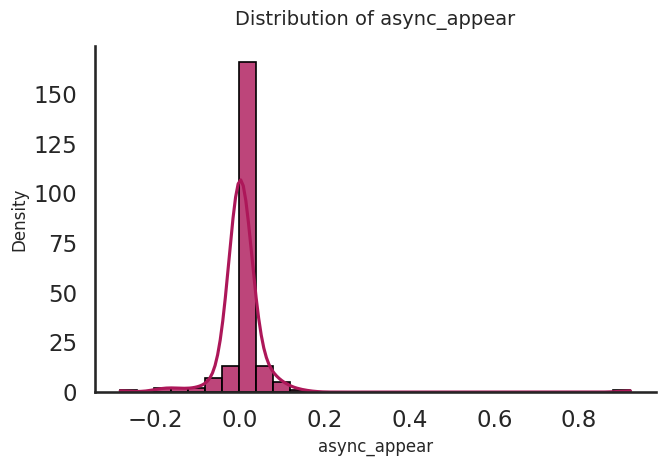

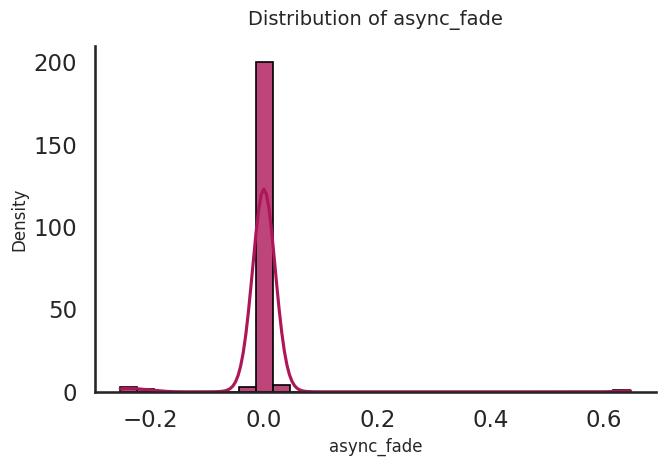

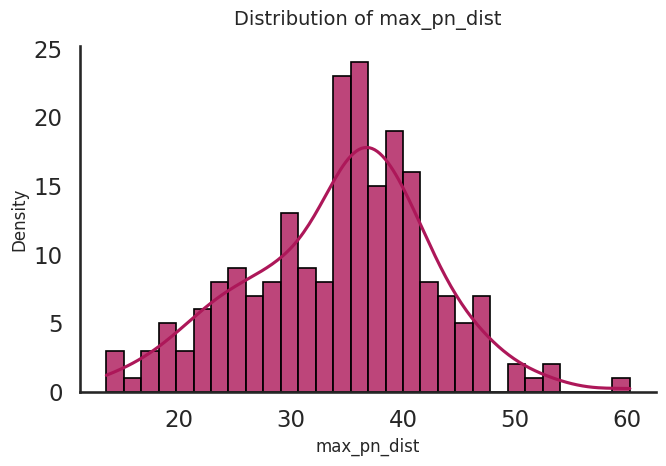

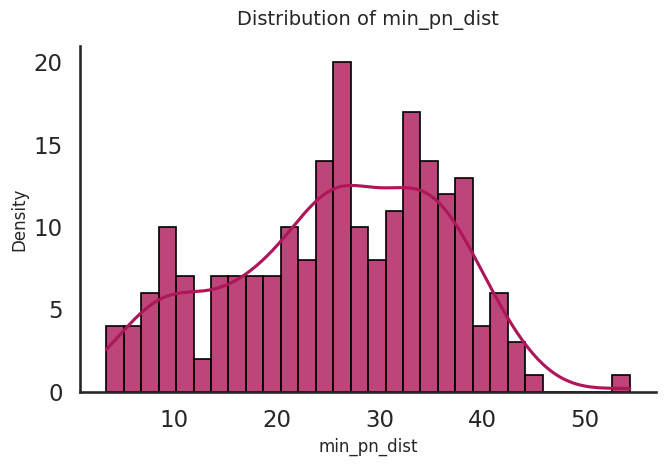

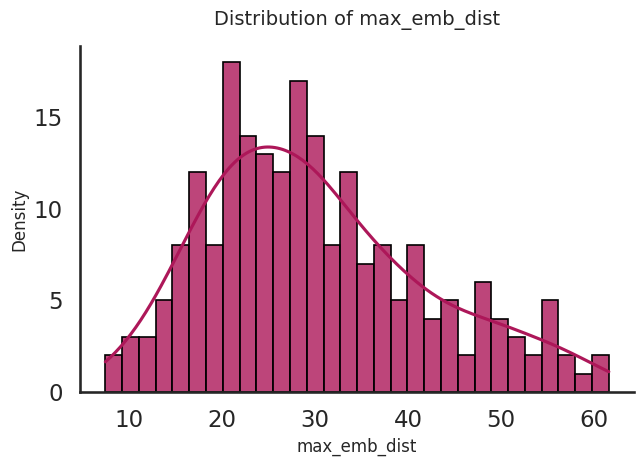

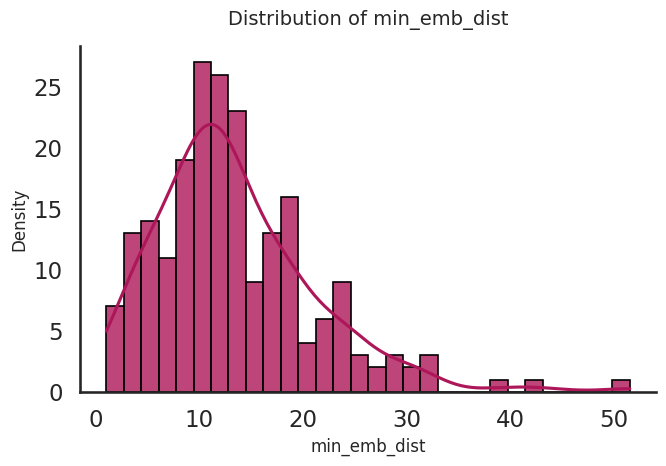

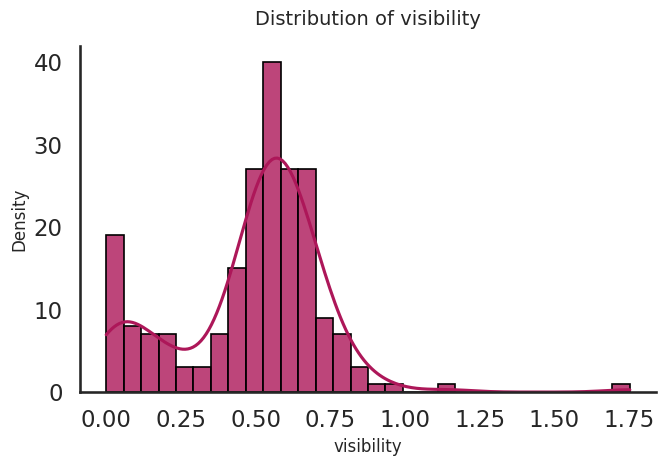

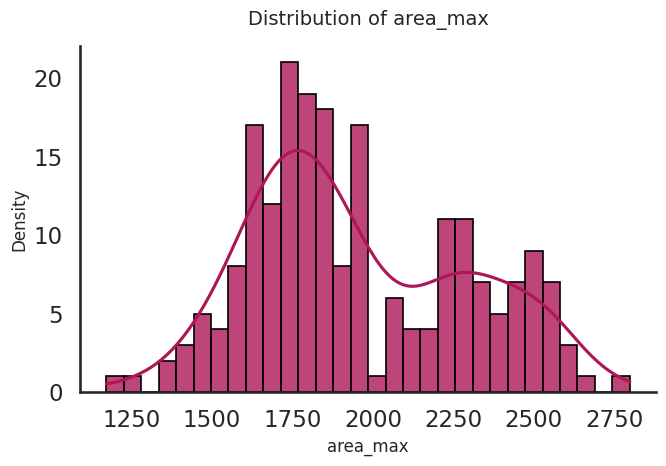

In [934]:
import seaborn as sns
import matplotlib.pyplot as plt
for feature in features:

    
    # Modern style and color palette
    sns.set_theme(style="white", context="talk")

    # Create the plot
    plt.figure(figsize=(7, 5))
    sns.histplot(
        X[feature],
        bins=30,
        kde=True,                             # Add KDE
        color=sns.color_palette("rocket")[2], # Modern color
        edgecolor="black",                    # Add black outline to bars
        linewidth=1.2,                        # Thickness of the bar edges
        alpha=0.8
    )

    # Beautify labels and title
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Distribution of {feature}", fontsize=14, pad=15)

    # Clean up spines for a modern aesthetic
    sns.despine()

    # Save high-res for paper
    plt.tight_layout()
    # plt.savefig("max_emb_dist_histogram_kde_outline.png", dpi=600)
    plt.show()

In [935]:
X['target'].value_counts()/X['target'].shape[0]

target
0.0    0.600939
2.0    0.328638
1.0    0.070423
Name: count, dtype: float64

In [936]:
"""
Multimodality check for a 1-D array `visibility`
------------------------------------------------
1. Hartigan’s dip test  -> p-value
2. Gaussian Mixture (1 vs 2 comps) -> BICs
"""

import numpy as np
from diptest import diptest                # pip install diptest
from sklearn.mixture import GaussianMixture

# TODO: replace with your data -------------------------------------------------
visibility = X['visibility'].values
# ------------------------------------------------------------------------------

# 1) Hartigan’s dip test
dip, p_value = diptest(visibility)
print(f"Hartigan’s dip = {dip:.4f},  p-value = {p_value:.4g}")

# 2) Gaussian-mixture BICs
visibility_2d = visibility.reshape(-1, 1)

bic = {}
for k in (1, 2):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(visibility_2d)
    bic[k] = gmm.bic(visibility_2d)
    print(f"{k}-component GMM BIC: {bic[k]:.2f}")

best_k = min(bic, key=bic.get)
print(f"Lower BIC favours {best_k}-component model")


Hartigan’s dip = 0.0338,  p-value = 0.08451
1-component GMM BIC: 13.86
2-component GMM BIC: -27.36
Lower BIC favours 2-component model


In [937]:
VISIBILITY_THRESHOLD_CUTTOF =  0.2
X["async_fade_group"] = (X["async_fade"]!=0).map({True: "High", False: "Low"})
from scipy.stats import chi2_contingency

table = pd.crosstab(X["async_fade_group"], X["target_label"])
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi2: {chi2:.3f}, p-value: {p:.5f}")


Chi2: 0.814, p-value: 0.66557


In [938]:
VISIBILITY_THRESHOLD_CUTTOF =  0.27
X["visibility_group"] = (X["visibility"] >=VISIBILITY_THRESHOLD_CUTTOF).map({True: "High", False: "Low"})
from scipy.stats import chi2_contingency

table = pd.crosstab(X["visibility_group"], X["target"])
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi2: {chi2:.3f}, p-value: {p:.5f}")


Chi2: 9.599, p-value: 0.00823


In [939]:
table

target,0.0,1.0,2.0
visibility_group,,,
High,109,14,48
Low,19,1,22


In [940]:
scipy.stats.fisher_exact(table)

SignificanceResult(statistic=0.0004889193353561751, pvalue=0.0118)

In [941]:
table 


target,0.0,1.0,2.0
visibility_group,,,
High,109,14,48
Low,19,1,22


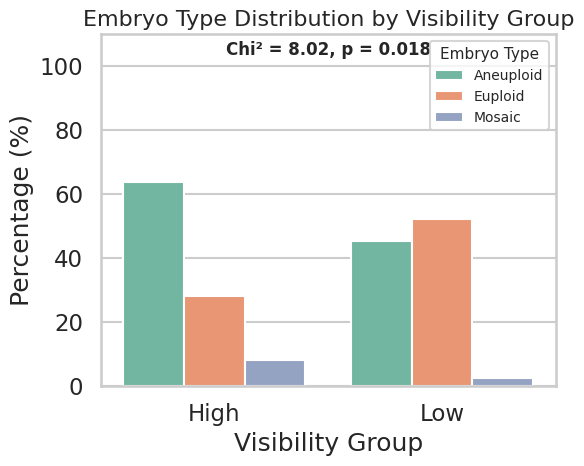

In [942]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute proportions (normalize="index" gives percentages per row)
prop_table = (
    pd.crosstab(X["visibility_group"], X["target_label"], normalize="index") * 100
).reset_index().melt(
    id_vars="visibility_group",
    var_name="Embryo Type",
    value_name="Percentage"
)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(6, 5))

# Barplot
ax = sns.barplot(
    x="visibility_group",
    y="Percentage",
    hue="Embryo Type",
    data=prop_table,
    palette="Set2"
)

# Annotate p-value
ax.text(
    0.5, 105, "Chi² = 8.02, p = 0.018", 
    ha="center", va="center", fontsize=12, fontweight="bold"
)

# Smaller legend
plt.legend(title="Embryo Type", fontsize=10, title_fontsize=11, loc="best")

# Labels
plt.title("Embryo Type Distribution by Visibility Group", fontsize=16)
plt.ylabel("Percentage (%)")
plt.xlabel("Visibility Group")
plt.ylim(0, 110)
plt.tight_layout()
plt.savefig("stacked_bar_visibility_chi2_smaller_legend.png", dpi=600)
plt.show()


In [895]:
table.values

array([[109,  14,  48],
       [ 19,   1,  22]])

In [896]:
import scipy
chi2,p,df,expected = scipy.stats.chi2_contingency(table.values)
chi2,p,df

(9.599218377043801, 0.008232963957190016, 2)

In [897]:
X['target'] = (X['target']==0)

In [902]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Kruskal-Wallis test
kruskal_result = kruskal(
    X.loc[X["target_label"] == "Aneuploid", "max_emb_dist"],
    X.loc[(X["target_label"] == "Mosaic"), "max_emb_dist"],
    X.loc[X["target_label"] == "Euploid", "max_emb_dist"],
)

print("Kruskal-Wallis test:", kruskal_result)

# If significant, do pairwise Dunn test
if kruskal_result.pvalue < 0.05:
    dunn_result = sp.posthoc_dunn(
        X, val_col="max_emb_dist", group_col="target_label"#, p_adjust="bonferroni"
    )
    print("Pairwise Dunn test:\n", dunn_result)


Kruskal-Wallis test: KruskalResult(statistic=6.6160853394161245, pvalue=0.036587717961755716)
Pairwise Dunn test:
            Aneuploid   Euploid    Mosaic
Aneuploid   1.000000  0.015481  0.187179
Euploid     0.015481  1.000000  0.999783
Mosaic      0.187179  0.999783  1.000000


In [903]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Kruskal-Wallis test
kruskal_result = kruskal(
    X.loc[X["target_label"] == "Aneuploid", "async_fade"],
    X.loc[X["target_label"] == "Mosaic", "async_fade"],
    X.loc[X["target_label"] == "Euploid", "async_fade"],
)
print("Kruskal-Wallis test:", kruskal_result)

# If significant, do pairwise Dunn test
if kruskal_result.pvalue < 0.10:
    dunn_result = sp.posthoc_dunn(
        X, val_col="async_fade", group_col="target_label", p_adjust="bonferroni"
    )
    print("Pairwise Dunn test:\n", dunn_result)


Kruskal-Wallis test: KruskalResult(statistic=0.3121876857472541, pvalue=0.8554789060051528)


In [904]:
y.loc[X['async_fade']!=0].value_counts()

target
False    19
True     10
Name: count, dtype: int64

In [905]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(X['async_appear']!=0, y)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

In [846]:
contingency_table

target,False,True
async_appear,,
False,86,51
True,44,32


In [847]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

# Fit models
full_model = smf.mnlogit('target ~ max_emb_dist', data=X).fit()
reduced_model = smf.mnlogit('target ~ 1', data=X).fit()

# Likelihood ratio test
lr_stat = 2 * (full_model.llf - reduced_model.llf)
df_diff = full_model.df_model - reduced_model.df_model
p_value = chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio statistic: {lr_stat}, p-value: {p_value}")


ValueError: endog has evaluated to an array with multiple columns that has shape (213, 2). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [848]:
import numpy as np
from scipy.stats import MonteCarloMethod
rng = np.random.default_rng()
method = MonteCarloMethod()
fisher_exact([[8, 2, 3], [1, 5, 4]], method=method)

NameError: name 'fisher_exact' is not defined

In [849]:
table

target,0.0,1.0,2.0
visibility_group,,,
High,109,14,48
Low,21,1,20


In [850]:
import scipy

In [851]:
from scipy.stats import fisher_exact

contingency = pd.crosstab(X['async_fade'] != 0, y).values
oddsratio, pvalue = fisher_exact(contingency, alternative='two-sided')
print("Fisher exact p-value =", pvalue)


Fisher exact p-value = 0.5174794037521744


In [416]:
# three-group comparison with Kruskal-Wallis + FDR correction
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import numpy as np

num_cols = X.select_dtypes(np.number).columns.drop('target')  # numeric, excl. label
pvals = []

for col in num_cols:
    g_eu  = X.loc[y == 'euploid',   col].dropna().values
    g_an  = X.loc[y == 'aneuploid', col].dropna().values
    g_mo  = X.loc[y == 'mosaic',    col].dropna().values
    if min(len(g_eu), len(g_an), len(g_mo)) < 5:   # skip tiny groups
        continue
    stat, p = kruskal(g_eu, g_an, g_mo)
    pvals.append((col, p))

# FDR (Benjamini–Hochberg)
cols, raw_p = zip(*pvals)
adj_p = multipletests(raw_p, method='fdr_bh')[1]

significant = [c for c, q in zip(cols, adj_p) if q < 0.05]
print("significant features:", significant)


ValueError: not enough values to unpack (expected 2, got 0)

In [417]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(X['visibility']>0.25, y)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

In [418]:
X['visibility_binary'] = X['visibility']>0.25
X['async_fade_binary'] = X['async_fade']>0.02

In [419]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import LabelEncoder

from scipy.stats import chi2
import numpy as np

# Encode class labels if needed
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_full = X[['max_emb_dist', 'visibility', 'async_fade_binary']].values # Full model: binary feature
X_reduced = np.ones((len(X), 1))       # Reduced model: intercept only

# Fit full model
full_model = LogisticRegression(multi_class='auto', solver='lbfgs',penalty=None).fit(X_full, y_encoded)

# Fit reduced model
reduced_model = LogisticRegression(multi_class='auto', solver='lbfgs',penalty=None).fit(X_reduced, y_encoded)

# Compute log-likelihoods
def multinomial_log_likelihood(model, X, y):
    probs = model.predict_proba(X)
    nll = -np.sum(np.log(probs[np.arange(len(y)), y]))
    return -nll  # Return log-likelihood (not negative)

ll_full = multinomial_log_likelihood(full_model, X_full, y_encoded)
ll_reduced = multinomial_log_likelihood(reduced_model,  X_reduced, y_encoded)

# Likelihood Ratio Test
lr_stat = 2 * (ll_full - ll_reduced)
df_diff = full_model.coef_.size  # Number of parameters in binary_feature
p_value = chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio statistic: {lr_stat:.4f}")
print(f"Degrees of freedom: {df_diff}")
print(f"p-value: {p_value:.6f}")


Likelihood Ratio statistic: 11.1490
Degrees of freedom: 9
p-value: 0.265635


/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/lin

In [319]:
from sklearn.model_selection import train_test_split,  StratifiedKFold

X_train,X_test, y_train, y_test = train_test_split(X_full,y_encoded, test_size=0.25, stratify=y_encoded)

In [320]:
full_model

LogisticRegression(multi_class='auto', penalty=None)

In [321]:
from sklearn.metrics import roc_auc_score

In [322]:
RepeatedStratifiedKFold?

Init signature: RepeatedStratifiedKFold(*, n_splits=5, n_repeats=10, random_state=None)
Docstring:     
Repeated Stratified K-Fold cross validator.

Repeats Stratified K-Fold n times with different randomization in each
repetition.

Read more in the :ref:`User Guide <repeated_k_fold>`.

Parameters
----------
n_splits : int, default=5
    Number of folds. Must be at least 2.

n_repeats : int, default=10
    Number of times cross-validator needs to be repeated.

random_state : int, RandomState instance or None, default=None
    Controls the generation of the random states for each repetition.
    Pass an int for reproducible output across multiple function calls.
    See :term:`Glossary <random_state>`.

Examples
--------
>>> import numpy as np
>>> from sklearn.model_selection import RepeatedStratifiedKFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([0, 0, 1, 1])
>>> rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2,
...     random_state=36851234)
>>> rskf.g

In [323]:
X_full

array([[43.53467352073075, 0.5560431818375946, False],
       [27.406520958234537, 0.8069609316409846, False],
       [57.08750256480594, 0.649760750152481, False],
       [15.87730326154671, 0.5868806775570796, False],
       [25.887601147643803, 0.6707207743509482, False],
       [17.22099711882824, 0.09416843735380098, False],
       [19.105495642975168, 0.03138947911793366, False],
       [29.413277289412, 0.052315798529889435, False],
       [55.23024217962278, 0.4392344984860725, False],
       [32.976556276172246, 0.7805793744628318, False],
       [37.64814720072138, 1.1419587144919205, False],
       [19.894865036266662, 0.5135986297988921, False],
       [44.68875563865725, 0.628072681862438, True],
       [40.051472878581514, 0.5338617795830723, False],
       [17.822197766103457, 0.41871512124162535, False],
       [48.77393542411296, 1.7526184702655883, False],
       [16.01553284289199, 0.6821258004618325, False],
       [28.391163118845732, 0.7141521740622816, False],
  

In [324]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_1samp   # or wilcoxon for non-normal data
import numpy as np

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)  # 5×200 = 1 000 folds
aucs = []

for train_idx, test_idx in rkf.split(X_full, y_encoded > 0):
    X_tr, X_te = X_full[train_idx], X_full[test_idx]
    y_tr, y_te = y_encoded[train_idx] > 0, y_encoded[test_idx] > 0
    
    clf = LogisticRegression(solver='lbfgs', penalty=None).fit(X_tr, y_tr)
    aucs.append(roc_auc_score(y_te, clf.predict_proba(X_te)[:, 1]))

aucs = np.array(aucs)

# one-sided test: H0 mean AUC = 0.5, H1 mean AUC > 0.5
t_stat, p_val = ttest_1samp(aucs, 0.5, alternative='greater')
print(f"mean AUC = {aucs.mean():.3f} ± {aucs.std(ddof=1):.3f}")
print(f"t = {t_stat:.2f},  one-sided p = {p_val:.3g}")


mean AUC = 0.587 ± 0.079
t = 34.86,  one-sided p = 3.57e-175


In [325]:

n_splits = 5
kfolds = StratifiedKFold(n_splits)

roc_aucs = []
for train_ids, test_ids in kfolds.split(X_full,y_encoded>0):
    X_train,X_test, y_train, y_test = X_full[train_ids], X_full[test_ids], y_encoded[train_ids], y_encoded[test_ids]

    full_model = LogisticRegression( solver='lbfgs',penalty=None).fit(X_train, y_train>0)
    



    roc_aucs.append(roc_auc_score(y_test>0,full_model.predict_proba(X_test)[:,1]))



In [326]:
full_model.predict_proba(X_test)[:,1]

array([0.29731053, 0.42991662, 0.48810041, 0.44683219, 0.23038219,
       0.42993618, 0.41458726, 0.36962327, 0.3668398 , 0.39072524,
       0.41846   , 0.32052489, 0.34600685, 0.41099409, 0.3228804 ,
       0.55192333, 0.57617699, 0.32337005, 0.42684923, 0.46886857,
       0.41502353, 0.36626784, 0.40474538, 0.26334085, 0.69458929,
       0.45839755, 0.38760742, 0.49280675, 0.39328981, 0.27902166,
       0.43959207, 0.42416656, 0.46827974, 0.26762067, 0.51100041,
       0.44631139, 0.27917792, 0.40974334, 0.37302287, 0.42036994,
       0.33665099, 0.37634547])

(array([  9.,  33.,  95., 174., 219., 209., 149.,  70.,  34.,   8.]),
 array([0.36199095, 0.4079095 , 0.45382805, 0.49974661, 0.54566516,
        0.59158371, 0.63750226, 0.68342081, 0.72933937, 0.77525792,
        0.82117647]),
 <BarContainer object of 10 artists>)

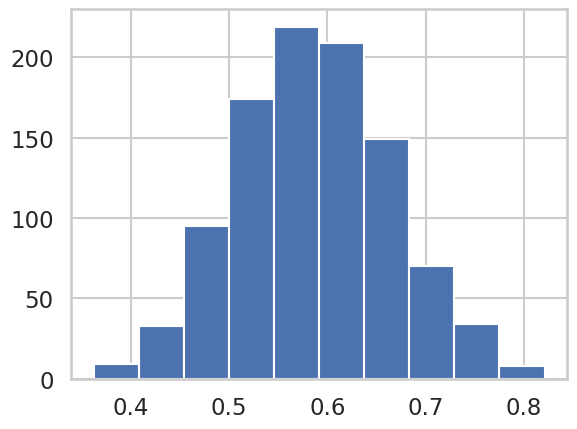

In [327]:
plt.hist(aucs)

In [205]:
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score ,average_precision_score

confusion_matrix(y_test>0,full_model.predict_proba(X_test)[:,1] >0.4)

array([[12, 12],
       [ 8,  8]])

In [248]:
roc_auc_score(y_test>0,full_model.predict_proba(X_test)[:,1])

0.5505882352941176

In [209]:
import numpy as np

def eta_squared(groups):
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean) ** 2 for g in groups)
    ss_total = sum((x - grand_mean) ** 2 for x in all_data)
    return ss_between / ss_total

groups = [X["visibility"][y == cls] for cls in np.unique(y)]
eta2 = eta_squared(groups)
print(f"Eta squared: {eta2:.4f}")


Eta squared: 0.0311


In [210]:
perm_p

NameError: name 'perm_p' is not defined

/tmp/ipykernel_28941/396565486.py:210: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(vec, nan_policy="omit")
/tmp/ipykernel_28941/396565486.py:211: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kt = kurtosis(vec, nan_policy="omit")
/tmp/ipykernel_28941/396565486.py:210: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(vec, nan_policy="omit")
/tmp/ipykernel_28941/396565486.py:211: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kt = kurtosis(vec, nan_policy="omit")
/tmp/ipy

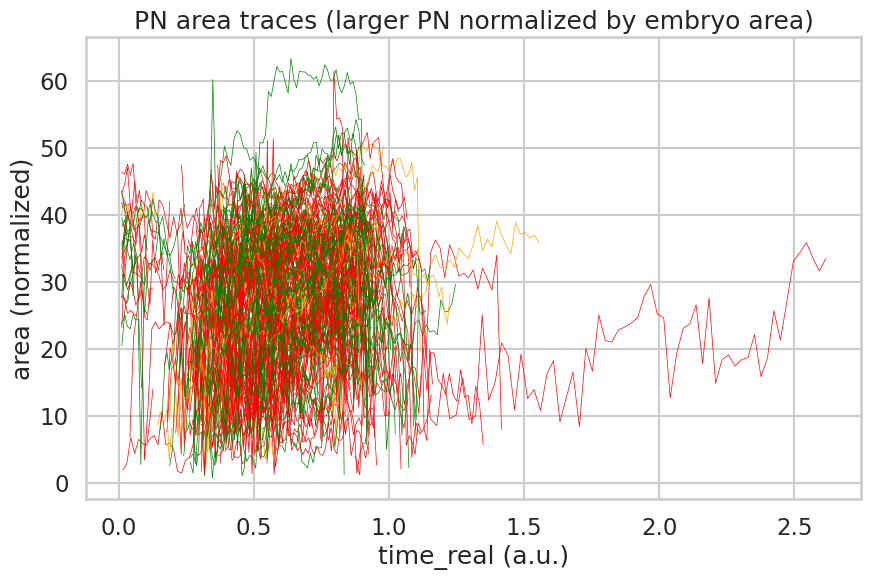

In [ ]:

smooth_cols = [
    "area", "extent", "aspect_ratio",
    "circularity", "solidity", "endpoints",
    "centroid_col", "centroid_row"
]
non_correl_to_area = ["extent", "aspect_ratio", "circularity", "solidity", "endpoints"]

colors = {0:'red', 1: 'orange', 2: 'green'}
records = []
plt.figure(figsize=(10, 6))

# ---- main loop ----
for embryo_id in merged_df.dropna(subset=["Class_Grade"])["embryo_id"]:
    try:
        # --- PN1 group & smoothing ---
        g1 = full_pn1_df[full_pn1_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)
        # derive time_real if needed
        if "time_real" not in g1.columns and "dt" in g1.columns:
            g1["time_real"] = g1["dt"].cumsum()

                
        g1["area"] = g1["area"].fillna(1)
        start1, len1 = find_signal(g1["area"].values != 1)
        pn1 = g1.iloc[start1 : start1 + len1].reset_index(drop=True)

        # pn1['time_real'] = pn1['time_real'] -pn1['time_real'].min()

        # pn2['time_real'] = pn2['time_real'] -pn2['time_real'].min()

        # --- PN2 group & smoothing ---
        g2 = full_pn2_df[full_pn2_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)
        if "time_real" not in g2.columns and "dt" in g2.columns:
            g2["time_real"] = g2["dt"].cumsum()

        g2["area"] = g2["area"].fillna(1)
        start2, len2 = find_signal(g2["area"].values != 1)
        pn2 = g2.iloc[start2 : start2 + len2].reset_index(drop=True)

        # skip if missing
        if pn1.empty or pn2.empty:
            continue

        # label larger vs smaller PN
        if pn1["area"].max() < pn2["area"].max():
            first_pn, second_pn = pn2, pn1
            first_start, first_len = start2, len2
            second_start, second_len = start1, len1
        else:
            first_pn, second_pn = pn1, pn2
            first_start, first_len = start1, len1
            second_start, second_len = start2, len2

        # --- whole-embryo track & smoothing ---
        whole_emb = whole_emb_all_df[whole_emb_all_df["embryo_id"] == embryo_id].copy().reset_index(drop=True)
        if "time_real" not in whole_emb.columns and "dt" in whole_emb.columns:
            whole_emb["time_real"] = whole_emb["dt"].cumsum()
        for col in ["area", "centroid_col", "centroid_row"]:
            if col in whole_emb.columns:
                whole_emb[col] = np.log(whole_emb[col])
        whole_emb_slice1 = whole_emb.iloc[first_start : first_start + first_len].reset_index(drop=True)
        whole_emb_slice2 = whole_emb.iloc[second_start : second_start + second_len].reset_index(drop=True)

        # --- area-based features ---
        area1 = first_pn["area"].values / whole_emb_slice1["area"].mean()
        area2 = second_pn["area"].values / whole_emb_slice2["area"].mean()
        t1 = first_pn["time_real"].values
        t2 = second_pn["time_real"].values

        auc1, auc2 = np.nansum(area1), np.nansum(area2)
        max_area1 = np.nanmax(area1) if area1.size else np.nan
        max_area2 = np.nanmax(area2) if area2.size else np.nan
        mean_area1 = np.nanmean(area1) if area1.size else np.nan
        mean_area2 = np.nanmean(area2) if area2.size else np.nan
        area_ratio = max_area1 / max_area2 if max_area2 and not np.isnan(max_area2) else np.nan
        area_diff = max_area1 - max_area2
        min_area = np.nanquantile(area1, 0.25)
        max_area1_q75 = np.nanquantile(area1, 0.75)

        # appearance/disappearance times
        start_time1 = first_pn["time_real"].iloc[0] if t1.size else np.nan
        start_time2 = second_pn["time_real"].iloc[0] if t2.size else np.nan
        end_time1   = first_pn["time_real"].iloc[-1] if t1.size else np.nan
        end_time2   = second_pn["time_real"].iloc[-1] if t2.size else np.nan
        appearance_diff    = start_time2 - start_time1
        disappearance_diff = end_time2 - end_time1

        # overlap duration
        overlap_start = max(start_time1, start_time2)
        overlap_end   = min(end_time1,   end_time2)
        overlap_duration = max(0.0, overlap_end - overlap_start)

        # time to max & growth rates
        idx_max1 = np.nanargmax(area1) if area1.size else None
        idx_max2 = np.nanargmax(area2) if area2.size else None
        t_max1 = first_pn["time_real"].iloc[idx_max1] if idx_max1 is not None else np.nan
        t_max2 = second_pn["time_real"].iloc[idx_max2] if idx_max2 is not None else np.nan
        growth_rate1 = ((max_area1 - area1[0]) / (t_max1 - start_time1)
                        if area1.size>1 and (t_max1-start_time1)>0 else np.nan)
        growth_rate2 = ((max_area2 - area2[0]) / (t_max2 - start_time2)
                        if area2.size>1 and (t_max2-start_time2)>0 else np.nan)

        # centroid distances
        df1 = first_pn[["time_real","centroid_col","centroid_row"]]
        df_emb1 = whole_emb_slice1[["time_real","centroid_col","centroid_row"]]\
                  .rename(columns={"centroid_col":"emb_x","centroid_row":"emb_y"})
        m1 = pd.merge(df1, df_emb1, on="time_real")
        distances1 = np.hypot(m1["centroid_col"]-m1["emb_x"], m1["centroid_row"]-m1["emb_y"])
        mean_dist1 = np.nanmean(distances1) if distances1.size else np.nan

        df2 = second_pn[["time_real","centroid_col","centroid_row"]]
        df_emb2 = whole_emb_slice2[["time_real","centroid_col","centroid_row"]]\
                  .rename(columns={"centroid_col":"emb_x","centroid_row":"emb_y"})
        m2 = pd.merge(df2, df_emb2, on="time_real")
        distances2 = np.hypot(m2["centroid_col"]-m2["emb_x"], m2["centroid_row"]-m2["emb_y"])
        mean_dist2 = np.nanmean(distances2) if distances2.size else np.nan

        # pairwise PN metrics
        df_pn1 = first_pn[["time_real","centroid_col","centroid_row","area"]]\
                 .rename(columns={"centroid_col":"x1","centroid_row":"y1","area":"area1"})
        df_pn2 = second_pn[["time_real","centroid_col","centroid_row","area"]]\
                 .rename(columns={"centroid_col":"x2","centroid_row":"y2","area":"area2"})
        ov = pd.merge(df_pn1, df_pn2, on="time_real")
        if not ov.empty:
            pdists = np.hypot(ov["x1"]-ov["x2"], ov["y1"]-ov["y2"])
            avg_pn_distance, min_pn_distance = np.nanmean(pdists), np.nanmin(pdists)
            final_pn_distance = pdists.iloc[-1]
            # midpoint
            emb_full = whole_emb[["time_real","centroid_col","centroid_row"]]\
                       .rename(columns={"centroid_col":"emb_x","centroid_row":"emb_y"})
            mid = ov.copy()
            mid["mid_x"], mid["mid_y"] = (ov["x1"]+ov["x2"])/2, (ov["y1"]+ov["y2"])/2
            mid = pd.merge(mid, emb_full, on="time_real")
            mid_d = np.hypot(mid["mid_x"]-mid["emb_x"], mid["mid_y"]-mid["emb_y"])
            mean_midpoint_dist = np.nanmean(mid_d)
            # correlation
            if ov["area1"].nunique()>1 and ov["area2"].nunique()>1:
                area_correlation = np.corrcoef(ov["area1"], ov["area2"])[0,1]
            else:
                area_correlation = np.nan
            # convergence rate
            times_ov = ov["time_real"].values
            if pdists.size>1 and np.ptp(times_ov)>0:
                slope, _ = np.polyfit(times_ov, pdists, 1)
                convergence_rate = slope
            else:
                convergence_rate = np.nan
            # PN meeting time
            emb_area0 = whole_emb.loc[whole_emb["time_real"]==times_ov[0],"area"].iloc[0]
            diam = 2*np.sqrt(emb_area0/np.pi)
            thresh = 0.15*diam
            below = (pdists<=thresh)
            pn_meeting_time = times_ov[np.argmax(below)] if below.any() else np.nan

            plt.plot(ov["time_real"].values,pdists,c=colors.get(int(merged_df.loc[merged_df["embryo_id"]==embryo_id, "y"].values[0])), lw=0.5)
        else:
            avg_pn_distance = min_pn_distance = final_pn_distance = np.nan
            mean_midpoint_dist = area_correlation = convergence_rate = pn_meeting_time = np.nan

        # fit quadratic to larger PN
        # A, B, C = np.polyfit(t1, area1, 2)

        # build record
        record = {
            "embryo_id": embryo_id,
            # "A": A, "B": B, "C": C,
            "eccentricity1": mean_dist1, "eccentricity2": mean_dist2,
            "lifetime1": end_time1-start_time1, "lifetime2": end_time2-start_time2,
            "auc1": auc1, "auc2": auc2,
            "max_area1": max_area1, "max_area2": max_area2,
            "mean_area1": mean_area1, "mean_area2": mean_area2,
            "area_ratio": area_ratio, "area_diff": area_diff,
            "min_area": min_area, "pn1_q75": max_area1_q75,
            "start_time1": start_time1, "start_time2": start_time2,
            "appearance_diff": appearance_diff,
            "end_time1": end_time1, "end_time2": end_time2,
            "disappearance_diff": disappearance_diff,
            "overlap_duration": overlap_duration,
            "growth_rate1": growth_rate1, "growth_rate2": growth_rate2,
            "async_start": abs(start_time1-start_time2),
            "async_fade": abs(end_time1-end_time2),
            "avg_pn_distance": avg_pn_distance,
            "min_pn_distance": min_pn_distance,
            "final_pn_distance": final_pn_distance,
            "mean_midpoint_dist": mean_midpoint_dist,
            "area_correlation": area_correlation,
            "convergence_rate": convergence_rate,
            "pn_meeting_time": pn_meeting_time,
            "target": merged_df.loc[merged_df["embryo_id"]==embryo_id, "y"].values[0]
        }

        # quantiles, skew, kurtosis for area
        for arr, prefix in [(area1, "area1"), (area2, "area2")]:
            q25, q50, q75 = np.nanquantile(arr, [0.25,0.5,0.75])
            sk = skew(arr, nan_policy="omit")
            kt = kurtosis(arr, nan_policy="omit")
            record.update({
                f"{prefix}_q25": q25,
                f"{prefix}_q50": q50,
                f"{prefix}_q75": q75,
                f"{prefix}_skewness": sk,
                f"{prefix}_kurtosis": kt
            })

        # non-area features via loop
        for feat in non_correl_to_area:
            v1 = first_pn[feat].values
            v2 = second_pn[feat].values
            for vec, suffix in [(v1, "1"), (v2, "2")]:
                q10, q50, q90 = np.nanquantile(vec, [0.10,0.5,0.90])
                sk = skew(vec, nan_policy="omit")
                kt = kurtosis(vec, nan_policy="omit")
                record.update({
                    f"{feat}{suffix}_q10": q10,
                    f"{feat}{suffix}_q50": q50,
                    f"{feat}{suffix}_q90": q90,
                    f"{feat}{suffix}_skewness": sk,
                    f"{feat}{suffix}_kurtosis": kt
                })

        records.append(record)

        # print(first_pn["time_real"].min())
        # # optional plot
        # plt.plot(
        #     ov["time_real"],
        #     pdists,# / whole_emb_slice1["area"].mean(),
        #     lw=0.5,
        #     color="green" if record["target"] else "red"
        # )

    
    except Exception as exc:
        print(f"{embryo_id} ERROR — {type(exc).__name__}: {exc!r}")
        raise  # re-raise so you actually see the traceback


# assemble results
features_df = pd.DataFrame(records)
plt.xlabel("time_real (a.u.)")
plt.ylabel("area (normalized)")
plt.title("PN area traces (larger PN normalized by embryo area)")
# plt.xlim(0,1)

plt.show()

df_metrics = features_df.copy()


In [ ]:
plt.hist(df_metrics['end_time1'],bins=20)

In [ ]:
plt.hist(df['tPNf']/24,bins=20)

In [ ]:
list(df.columns)[:30]

In [ ]:
np.random.normal(0.05, 0.02, size=28)

In [ ]:
df_metrics.loc[df_metrics['lifetime1']<0.15,'lifetime1'].shape

In [ ]:
df_metrics = df_metrics.loc[df_metrics['lifetime1']<1.5]

In [ ]:
df_metrics.loc[df_metrics['lifetime1']<0.15,'lifetime1']+= np.random.normal(0.05, 0.01, size=28)

In [ ]:
df_metrics.drop('embryo_id',axis=1)

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
X_feat, y = df_metrics.drop(['embryo_id','SUBGROUPS OF 0','target'],axis=1), df_metrics['target']

In [ ]:
f_statistic, p_values = f_classif(X.fillna(0),y)

In [ ]:
plt.scatter(df_metrics['auc1'],df_metrics['lifetime1'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, f_classif
from statsmodels.stats.multitest import fdrcorrection

# 0️⃣  Clean obvious numerical issues ------------------------------------
X = (X                      # your aggregated feature frame
        .replace([np.inf, -np.inf], np.nan)
        .dropna(axis=1))         # drop cols that still contain NaNs


# X = your feature frame
import numpy as np
import pandas as pd

corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

X_pruned = X.drop(columns=to_drop)

# 1️⃣  Drop features with zero variance ---------------------------------
vt = VarianceThreshold()         # by default keeps var > 0
X_nz = pd.DataFrame(
    vt.fit_transform(X_pruned),
    columns=X_pruned.columns[vt.get_support()]
)

# 2️⃣  ANOVA -------------------------------------------------------------
# if you’re on scikit-le
#arn >=1.1 you can add force_finite=True here
F, p = f_classif(X_nz, y)

# 3️⃣  FDR correction ----------------------------------------------------
_, p_fdr = fdrcorrection(p, alpha=0.1)

anova_df = (pd.DataFrame({
                "feature": X_nz.columns,
                "F": F,
                "p_raw": p,
                "p_fdr": p_fdr})
            .sort_values("p_fdr"))

selected = anova_df.query("p_fdr < 0.05").feature.tolist()


In [ ]:
X_feat

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier          # fast & strong
from sklearn.metrics import balanced_accuracy_score
import shap

# X_feat : your feature DataFrame
# y      : 1-D array-like with 3-class target
# ──────────────────────────────────────────────────────────────
# 0️⃣  Prune near-duplicates (|ρ| > .90) – optional but helps power
corr = X_feat.fillna(0).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
dup_cols = [c for c in upper.columns if any(upper[c] > 0.91)]
X = X_feat.fillna(0)

# 1️⃣  Train / CV a Gradient Boosting tree model
gb = RandomForestClassifier(random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_score = cross_val_score(gb, X, y, cv=cv,
                           scoring='balanced_accuracy').mean()
print(f'5-fold balanced accuracy: {cv_score:.3f}')

gb.fit(X, y)

# 2️⃣  Built-in (Gini) feature importances
imp = pd.Series(gb.feature_importances_, index=X.columns) \
         .sort_values(ascending=False)
print("\nTop features by model importance:")
print(imp.head(10))

# 3️⃣  SHAP values for deeper insight


In [ ]:
X

In [ ]:
y.value_counts()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe =LogisticRegressionCV(penalty="l1", solver="saga",
                                          cv=5, multi_class="multinomial",
                                          scoring="roc_auc",
                                          max_iter=10000)

In [ ]:
key        = next(iter(pipe.scores_))          # 'multinomial' or the first class label
best_col   = np.argmax(np.mean(pipe.scores_[key], axis=0))   # col = best-C
cv_score   = np.mean(pipe.scores_[key][:, best_col])
print(f"5-fold CV balanced-accuracy: {cv_score:.3f}")

In [ ]:
log.__dict__

In [ ]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)      # requires an active notebook


In [ ]:
p

In [ ]:
selected

In [ ]:
for idx, feat in enumerate(X.columns):

    print(p_values[idx], feat)

In [ ]:
X

In [ ]:
p_values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

# Fit GMM
data = df_metrics['overlap_duration'].fillna(0).values[:,None]
gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

# Predict labels
labels = gmm.predict(data.reshape(-1, 1))

# Plot
x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
responsibilities = gmm.predict_proba(x)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(8, 4))
plt.hist(data, bins=20, density=True, alpha=0.5, label="Data")

for i in range(2):
    plt.plot(x, pdf_individual[:, i], label=f"Gaussian {i+1}")

plt.plot(x, pdf, '--', color='black', label="Mixture")
plt.xlabel("lifetime1")
plt.ylabel("Density")
plt.title("Fitted Gaussian Mixture")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Get data (simulate placeholder similar to what the user might have)
np.random.seed(0)

# Fit GMM
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data)

# Generate N simulated samples from the fitted GMM
N = 1000
n_samples = len(data)
simulated_qs = []

for _ in range(N):
    # Sample from the GMM
    component_samples = []
    n1 = np.random.binomial(n_samples, gmm.weights_[0])
    n2 = n_samples - n1
    comp0 = np.random.normal(gmm.means_[0, 0], np.sqrt(gmm.covariances_[0, 0]), n1)
    comp1 = np.random.normal(gmm.means_[1, 0], np.sqrt(gmm.covariances_[1, 0]), n2)
    sim_data = np.concatenate([comp0, comp1])
    sim_data.sort()
    simulated_qs.append(sim_data)

# Sort actual data
data_sorted = np.sort(data.flatten())

# Compute the median and envelope
simulated_qs = np.array(simulated_qs)
lower = np.percentile(simulated_qs, 2.5, axis=0)
upper = np.percentile(simulated_qs, 97.5, axis=0)
median = np.median(simulated_qs, axis=0)

# Plot the QQ-envelope
plt.figure(figsize=(8, 6))
plt.plot(data_sorted, median, label='Median simulated', color='black')
plt.fill_between(data_sorted, lower, upper, color='gray', alpha=0.3, label='95% envelope')
plt.plot(data_sorted, data_sorted, linestyle='--', color='red', label='Ideal QQ')
plt.xlabel('Observed quantiles')
plt.ylabel('Simulated quantiles')
plt.title('QQ Envelope for GMM Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Fit 1-component GMM to actual data
gmm1 = GaussianMixture(n_components=1, random_state=0)
gmm1.fit(data)

# Generate N simulated samples from the 1-component GMM
simulated_qs_1gmm = []
for _ in range(N):
    sim_data = np.random.normal(gmm1.means_[0, 0], np.sqrt(gmm1.covariances_[0, 0]), n_samples)
    sim_data.sort()
    simulated_qs_1gmm.append(sim_data)

# Compute envelope for 1-GMM
simulated_qs_1gmm = np.array(simulated_qs_1gmm)
lower_1gmm = np.percentile(simulated_qs_1gmm, 2.5, axis=0)
upper_1gmm = np.percentile(simulated_qs_1gmm, 97.5, axis=0)
median_1gmm = np.median(simulated_qs_1gmm, axis=0)

# Plot QQ Envelope for 1-Component GMM
plt.figure(figsize=(8, 6))
plt.plot(data_sorted, median_1gmm, label='Median simulated (1-GMM)', color='blue')
plt.fill_between(data_sorted, lower_1gmm, upper_1gmm, color='blue', alpha=0.2, label='95% envelope (1-GMM)')
plt.plot(data_sorted, data_sorted, linestyle='--', color='red', label='Ideal QQ')
plt.xlabel('Observed quantiles')
plt.ylabel('Simulated quantiles')
plt.title('QQ Envelope for 1-Component GMM Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
gmm1 = GaussianMixture(n_components=1).fit(data)
gmm2 = GaussianMixture(n_components=2).fit(data)

ll1 = gmm1.score(data)#.sum()
ll2 = gmm2.score(data)#.sum()

# Likelihood ratio statistic
lr_stat = 2 * (ll2 - ll1)

In [ ]:
lr_stat

In [ ]:
from scipy.stats import chi2
p_value = chi2.sf(lr_stat, df=2)
print(f"LR stat = {lr_stat:.3f}, p = {p_value:.4f}")


In [ ]:
plt.hist(group1)
plt.hist(group2)

In [ ]:
df_metrics = pd.merge(df_metrics, merged_df[['embryo_id', 'SUBGROUPS OF 0']])

In [ ]:
df_metrics.loc[df_metrics['SUBGROUPS OF 0'].isna(), 'SUBGROUPS OF 0'] = df_metrics.loc[df_metrics['SUBGROUPS OF 0'].isna(), 'target'] 

df_metrics.loc[df_metrics['SUBGROUPS OF 0'].eq("0a"), 'SUBGROUPS OF 0'] = 3


df_metrics.loc[df_metrics['SUBGROUPS OF 0'].eq("0b"), 'SUBGROUPS OF 0'] = 4

In [ ]:
df_metrics['SUBGROUPS OF 0'].value_counts()

In [ ]:
df_metrics

In [ ]:
from scipy import stats
sub1 = df_metrics.loc[df_metrics['overlap_duration']<0.23]
sub2 = df_metrics.loc[df_metrics['overlap_duration']>0.23]

c = np.array([sub1['SUBGROUPS OF 0'].value_counts().sort_index().tolist(),sub2['SUBGROUPS OF 0'].value_counts().sort_index().tolist()])
chi2, p, dof, expected = stats.chi2_contingency(c)

print(p)


In [ ]:
sub2

In [ ]:
c/x

In [ ]:
from scipy import stats
sub1 = df_metrics.loc[df_metrics['min_pn_distance']<15]
sub2 = df_metrics.loc[df_metrics['min_pn_distance']>15]

c = np.array([sub1['target'].value_counts().sort_index().tolist(),sub2['target'].value_counts().sort_index().tolist()])
chi2, p, dof, expected = stats.chi2_contingency(c)

print(p)


In [ ]:
c

In [ ]:
import numpy as np

# c: your contingency table, shape = (3, n_subgroups)
# e.g. c = np.array([
#   [counts_class0_sub0, counts_class0_sub1, …],
#   [counts_class1_sub0, counts_class1_sub1, …],
#   [counts_class2_sub0, counts_class2_sub1, …],
#])

draws = 20_000
alpha = 0.5  # Jeffreys‐like prior

# 1) Sample Dirichlet posteriors for each class
# samples[j] has shape (draws, n_subgroups), giving posterior p’s for class j
samples = [
    np.random.dirichlet(c[j] + alpha, size=draws)
    for j in range(3)
]

# 2) For each subgroup k, you now have samples[0][:,k], samples[1][:,k], samples[2][:,k]
#    You can compare any pair, e.g. class 2 vs class 0:
results = {}
for k in range(c.shape[1]):
    p0 = samples[0][:, k]
    p1 = samples[1][:, k]
    p2 = samples[2][:, k]
    # difference between class2 and class0
    diff20 = p2 - p0
    results[f"subgroup_{k}_2vs0"] = {
        "mean_diff": diff20.mean(),
        "CI_95%": np.percentile(diff20, [2.5, 97.5]),
        "P(p2>p0)": (diff20 > 0).mean()
    }
    # likewise for 1 vs 0, 2 vs 1, etc.

# 3) Inspect
for k, v in results.items():
    print(k, v)
p

In [ ]:
sub1['SUBGROUPS OF 0'].value_counts().sort_index()/sub1.shape[0]

In [ ]:
sub2['SUBGROUPS OF 0'].value_counts().sort_index()/sub2.shape[0]

In [ ]:
draws = 20000
alpha = 0.5
samples1 = np.random.dirichlet(c[0] + alpha, size=draws)
samples2 = np.random.dirichlet(c[1] + alpha, size=draws)

# Measure L1 distance between the two sampled distributions
dists = np.abs(samples1 - samples2).sum(axis=1)

print(f"Posterior mean L1 distance: {dists.mean():.3f}")
print(f"95% CI: {np.percentile(dists, [2.5, 97.5])}")


In [ ]:
import numpy as np

# your 2×3 contingency table
c = np.array([[20, 18,  1],
              [49,109, 14]])

n1, n2 = c[0].sum(), c[1].sum()
draws = 200_000
alpha = 0.5  # Jeffreys‐like prior

results = {}
for k in range(c.shape[1]):
    a1 = c[0, k] + alpha
    b1 = n1 - c[0, k] + alpha
    a2 = c[1, k] + alpha
    b2 = n2 - c[1, k] + alpha

    p1 = np.random.beta(a1, b1, size=draws)
    p2 = np.random.beta(a2, b2, size=draws)
    diff = p2 - p1

    results[f"subgroup_{k}"] = {
        "mean_diff": diff.mean(),
        "95% CI": np.percentile(diff, [2.5, 97.5]),
        "P(p2>p1)": (diff > 0).mean()
    }

# print the summary
for name, stats in results.items():
    print(f"{name}: mean diff = {stats['mean_diff']:.3f}, "
          f"95% CI = [{stats['95% CI'][0]:.3f}, {stats['95% CI'][1]:.3f}], "
          f"P(p2>p1) = {stats['P(p2>p1)']:.3f}")


In [ ]:
df_metrics['target'].value_counts()

In [ ]:
from scipy import stats
sub1 = c.loc[df_metrics['lifetime2']<0.25]
sub2 = df_metrics.loc[df_metrics['lifetime2']>0.25]

table = np.array([[20,18,1],[49,109,14]])
chi2, p, dof, expected = stats.chi2_contingency(table)
oddsratio, colors = stats.fisher_exact(table)

In [ ]:
c

In [ ]:

sub1 = df_metrics.loc[df_metrics['async_start']==0]

In [ ]:
sub2 = df_metrics.loc[df_metrics['async_start']>0]

In [ ]:
df_metrics['target'].value_counts()/df_metrics.shape[0]

In [ ]:
sub1['target'].value_counts()/sub1.shape[0]

In [ ]:
sub2['target'].value_counts()/sub2.shape[0]

In [ ]:
import scipy.stats as stats

In [ ]:
table = np.array([[20,18,1],[49,109,14]])
chi2, p, dof, expected = stats.chi2_contingency(table)
oddsratio, p_fisher = stats.fisher_exact(table)

In [ ]:
import numpy as np, scipy.stats as stats, numpy.random as rnd

# original table
c = np.array([[20, 18,  1],
                  [49,109, 14]])

# observed G-statistic
g_obs = stats.chi2_contingency(table, lambda_='log-likelihood')[0]

# build “individual-level” arrays
groups = np.array([0]*table[0].sum() + [1]*table[1].sum())          # 0=short, 1=long
categories = np.repeat([0, 1, 2], table.sum(axis=0))                # 0,1,2 = ane, mos, eu

B = 100_0
ge = 0
for _ in range(B):
    perm_groups = rnd.permutation(groups)            # shuffle **labels**, not counts
    perm_table  = np.histogram2d(perm_groups, categories,
                                 bins=[2, 3])[0].astype(int)
    g_perm = stats.chi2_contingency(perm_table,
                                    lambda_='log-likelihood')[0]
    ge += g_perm >= g_obs

p_mc = (ge + 1) / (B + 1)
print(f"G = {g_obs:.2f}, Monte-Carlo p ≈ {p_mc:.4f}")


In [ ]:
np.sum(c,axis=0)

In [ ]:
import numpy as np

# your 2×3 contingency table
c = np.array([[20, 18,  1],
              [49,109, 14]])

n1, n2 = c[0].sum(), c[1].sum()
draws = 200_000
alpha = 0.5  # Jeffreys‐like prior

results = {}
for k in range(c.shape[1]):
    a1 = c[0, k] + alpha
    b1 = n1 - c[0, k] + alpha
    a2 = c[1, k] + alpha
    b2 = n2 - c[1, k] + alpha

    p1 = np.random.beta(a1, b1, size=draws)
    p2 = np.random.beta(a2, b2, size=draws)
    diff = p2 - p1

    results[f"subgroup_{k}"] = {
        "mean_diff": diff.mean(),
        "95% CI": np.percentile(diff, [2.5, 97.5]),
        "P(p2>p1)": (diff > 0).mean()
    }

# print the summary
for name, stats in results.items():
    print(f"{name}: mean diff = {stats['mean_diff']:.3f}, "
          f"95% CI = [{stats['95% CI'][0]:.3f}, {stats['95% CI'][1]:.3f}], "
          f"P(p2>p1) = {stats['P(p2>p1)']:.3f}")


In [ ]:
df_metrics

In [ ]:
smf.logit?

In [ ]:
# 0.  Make the Boolean column numeric
df_metrics["target_num"] = df_metrics["target"].astype(int)   # True→1, False→0

# 1.  Fit the logistic model with lifetime1 as a continuous predictor
import statsmodels.formula.api as smf
model = smf.logit("target_num ~ lifetime1", data=df_metrics).fit()
print(model.summary())

# 2.  Draw the fitted probability curve (optional)
import numpy as np, matplotlib.pyplot as plt
grid = np.linspace(df_metrics["lifetime1"].min(),
                   df_metrics["lifetime1"].max(), 200)
pred = model.predict({"lifetime1": grid})

plt.plot(grid, pred)
plt.xlabel("lifetime1 (days)")
plt.ylabel("Predicted P(euploid)")
plt.ylim(0, 1)
plt.title("Logistic-regression fit")
plt.show()


In [ ]:
df_metrics['convergence_rate'].hist(bins=20)

In [ ]:
df_metrics.columns

In [ ]:
merged_df['y'].value_counts()/merged_df['y'].shape

In [ ]:
df_metrics['target'].value_counts()/df_metrics['target'].shape[0]

In [ ]:
df_metrics['target'].value_counts()/df_metrics['target'].shape[0]

In [ ]:
import numpy as np
import pandas as pd

def find_signal(mask: np.ndarray):
    """Return (start_idx, length) of the longest contiguous True stretch in *mask*."""
    best_start = 0
    best_len = 0
    cur_start = None
    cur_len = 0
    for idx, flag in enumerate(mask):
        if flag:
            if cur_start is None:
                cur_start = idx
                cur_len = 1
            else:
                cur_len += 1
            if cur_len > best_len:
                best_start = cur_start
                best_len = cur_len
        else:
            cur_start = None
            cur_len = 0
    return best_start, best_len

records = []




        # Label larger vs. smaller PN by peak median_intensity
        peak1 = pn1["median_intensity"].max() if not pn1["median_intensity"].isna().all() else np.nan
        peak2 = pn2["median_intensity"].max() if not pn2["median_intensity"].isna().all() else np.nan
        if peak2 > peak1:
            first_pn, second_pn = pn2, pn1
            first_start, first_len = start2, len2
            second_start, second_len = start1, len1
        else:
            first_pn, second_pn = pn1, pn2
            first_start, first_len = start1, len1
            second_start, second_len = start2, len2

        # Compute intensity‐based features for a given PN DataFrame
        def compute_intensity_features(pn_df, prefix):
            arr_mean = pn_df["mean_intensity"].values
            arr_med = pn_df["median_intensity"].values
            arr_std = pn_df["std_intensity"].values
            t = pn_df["time"].values

            auc_mean = np.nansum(arr_mean)
            auc_med = np.nansum(arr_med)
            max_mean = np.nanmax(arr_mean) if arr_mean.size > 0 else np.nan
            max_med = np.nanmax(arr_med) if arr_med.size > 0 else np.nan
            mean_mean = np.nanmean(arr_mean) if arr_mean.size > 0 else np.nan
            mean_med = np.nanmean(arr_med) if arr_med.size > 0 else np.nan

            start_time = t[0] if t.size > 0 else np.nan
            end_time = t[-1] if t.size > 0 else np.nan

            idx_peak = np.nanargmax(arr_med) if arr_med.size > 0 else None
            t_peak = t[idx_peak] if idx_peak is not None else np.nan
            growth_med = (
                (max_med - arr_med[0]) / (t_peak - start_time)
                if (arr_med.size > 1 and (t_peak - start_time) > 0)
                else np.nan
            )

            return {
                f"{prefix}_auc_mean": auc_mean,
                f"{prefix}_auc_med": auc_med,
                f"{prefix}_max_mean": max_mean,
                f"{prefix}_max_med": max_med,
                f"{prefix}_mean_mean": mean_mean,
                f"{prefix}_mean_med": mean_med,
                f"{prefix}_start_time": start_time,
                f"{prefix}_end_time": end_time,
                f"{prefix}_growth_med": growth_med,
                f"{prefix}_std_mean": np.nanmean(arr_std) if arr_std.size > 0 else np.nan,
                f"{prefix}_skew_med": pn_df["skewness"].mean() if "skewness" in pn_df else np.nan,
                f"{prefix}_kurt_med": pn_df["kurtosis"].mean() if "kurtosis" in pn_df else np.nan,
                f"{prefix}_entropy": pn_df["entropy"].mean() if "entropy" in pn_df else np.nan,
                f"{prefix}_p10": pn_df["percentile_10"].mean() if "percentile_10" in pn_df else np.nan,
                f"{prefix}_p25": pn_df["percentile_25"].mean() if "percentile_25" in pn_df else np.nan,
                f"{prefix}_p75": pn_df["percentile_75"].mean() if "percentile_75" in pn_df else np.nan,
                f"{prefix}_p90": pn_df["percentile_90"].mean() if "percentile_90" in pn_df else np.nan,
            }

        feats1 = compute_intensity_features(first_pn, "pn1")
        feats2 = compute_intensity_features(second_pn, "pn2")

        # Pairwise features
        start1 = feats1["pn1_start_time"]
        start2 = feats2["pn2_start_time"]
        end1 = feats1["pn1_end_time"]
        end2 = feats2["pn2_end_time"]

        appearance_diff = start2 - start1
        disappearance_diff = end2 - end1
        overlap_start = max(start1, start2)
        overlap_end = min(end1, end2)
        overlap_dur = overlap_end - overlap_start if overlap_end > overlap_start else 0.0

        df1 = first_pn[["time", "median_intensity"]].rename(columns={"median_intensity": "med1"})
        df2 = second_pn[["time", "median_intensity"]].rename(columns={"median_intensity": "med2"})
        df_ov = pd.merge(df1, df2, on="time", how="inner")
        if not df_ov.empty and df_ov["med1"].nunique() > 1 and df_ov["med2"].nunique() > 1:
            corr = np.corrcoef(df_ov["med1"].values, df_ov["med2"].values)[0, 1]
        else:
            corr = np.nan

        record = {
            "embryo_id": embryo_id,
            "appearance_diff": appearance_diff,
            "disappearance_diff": disappearance_diff,
            "overlap_duration": overlap_dur,
            "median_corr": corr,
            
            "target": merged_df.loc[merged_df["embryo_id"] == embryo_id, "y"].values[0],
        }
        record.update(feats1)
        record.update(feats2)
        records.append(record)
        plt.plot(first_pn["median_intensity"])

    except Exception as exc:
        print(f"{embryo_id}: {exc}")

intensity_features_df = pd.DataFrame(records)


In [ ]:
intensity_features_df['target']

In [ ]:
from scipy.stats import mannwhitneyu

pos_group = intensity_features_df.loc[intensity_features_df['target']==2]
neg_group = intensity_features_df.loc[intensity_features_df['target']==0]

relevant_cols = []
for col in intensity_features_df.columns[1:]:
    if col=='target':
        continue




    res = mannwhitneyu(pos_group[col].fillna(0), neg_group[col].fillna(0))#
    # res  =pointbiserialr(df_metrics['target'], df_metrics[col].fillna(df_metrics[col].mean()))

    print(f"==== {col}")
    print(res.pvalue)
    if res.pvalue<0.05:
        print(res.statistic)
        relevant_cols.append(col)
    
    

In [ ]:
from scipy.stats import mannwhitneyu,pointbiserialr


pos_group = df_metrics.loc[df_metrics['target']==True]
neg_group = df_metrics.loc[df_metrics['target']==False]

# relevant_cols = []
for col in df_metrics.columns[1:]:
    if col=='target':
        continue




    res = mannwhitneyu(pos_group[col].fillna(0), neg_group[col].fillna(0))#
    # res  =pointbiserialr(df_metrics['target'], df_metrics[col].fillna(df_metrics[col].mean()))

    if res.pvalue<0.05:
        print(f"==== {col}")
        print(res.statistic)
        relevant_cols.append(col)
    
    


In [ ]:
df_metrics['aspect_ratio1_kurtosis'].hist()

In [ ]:
relevant_cols

In [ ]:
time_features = [
    'Age',
    'tPNf',
    't2',
    't3',
    't4',
    't5',
    't6',
    't7',
    't8',
]

In [ ]:
metrics_plus_clinical = pd.merge(df_metrics,merged_df, on='embryo_id')

metrics_plus_clinical = pd.merge(metrics_plus_clinical,intensity_features_df.drop('target', axis=1), on='embryo_id')

In [ ]:
plt.hist(metrics_plus_clinical['lifetime1'], bins=30)

In [ ]:
X = metrics_plus_clinical[relevant_cols[1:3]].fillna(metrics_plus_clinical[relevant_cols[1:3]].mean())

X = metrics_plus_clinical[relevant_cols[1:-1]+time_features].fillna(metrics_plus_clinical[relevant_cols[1:-1]+time_features].mean())

y = metrics_plus_clinical['target']

In [ ]:
y.value_counts()/y.shape

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

In [ ]:
relevant_cols

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np


# Assume df_metrics is still in memory; if not, raise.
try:
    df = metrics_plus_clinical.copy()
except NameError:
    raise RuntimeError("DataFrame df_metrics is not available in this session.")

# Rename target to numeric if not yet
if "target_num" not in df.columns:
    df["target_num"] = (df["target"]>0).astype(int)

features = relevant_cols[2:-1]

# Keep only rows without missing in these columns
model_df = df[["target_num"] + features].fillna(df[["target_num"] + features].mean())

# Build formula
formula = "target_num ~ " + " + ".join(features)

model_mult = smf.logit(formula, data=model_df).fit(disp=False)

# Prepare coefficient table with OR
coef_table = model_mult.summary2().tables[1]
coef_table["OR"] = np.exp(coef_table["Coef."])
coef_table["OR_lower"] = np.exp(coef_table["[0.025"])
coef_table["OR_upper"] = np.exp(coef_table["0.975]"])

# tools.display_dataframe_to_user("Multivariable logistic regression", coef_table)


print(model_mult.summary())


In [ ]:
metrics_plus_clinical

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from patsy import bs

# ---------- CONFIG ----------
features =  relevant_cols[2:-1]
df_spline_df = 1        # degrees‑of‑freedom for each spline
grid_pts     = 200             # resolution of the prediction grid
spline_degree =1
# -----------------------------

if "df_metrics" not in globals():
    print("`df_metrics` is not in memory ‑‑ load / rebuild it, then rerun this cell.")
else:
    df = metrics_plus_clinical.copy()
    df["target_num"] = (df["target"]>0).astype(int)

    # drop rows with NA in any required column
    model_df = df[["target_num"] + features].dropna()

    # build spline formula
    spline_terms = [f"bs({v}, df={df_spline_df}, degree={spline_degree})" for v in features]
    formula = "target_num ~ " + " + ".join(spline_terms)

    model = smf.logit(formula, data=model_df).fit(disp=False)
    print(model.summary())

    # median reference values
    med_vals = model_df[features].median()

    for var in features:
        grid = np.linspace(model_df[var].min(), model_df[var].max(), grid_pts)

        # one row per grid point, all other vars fixed at their median
        pred_df = pd.DataFrame(
            {v: med_vals[v] for v in features},
            index=np.arange(len(grid))          # ← fixes the ValueError
        )
        pred_df[var] = grid

        pred = model.predict(pred_df)

        plt.figure(figsize=(5, 4))
        plt.plot(grid, pred)
        plt.xlabel(var)
        plt.ylabel("Predicted P(euploid)")
        plt.title(f"Spline-logit: effect of {var}\n(other vars at median)")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()


In [ ]:
# one-liner: decorrelate while keeping all variance
from sklearn.decomposition import PCA
X_std   = (X - X.mean()) / X.std()
X_ortho = PCA().fit_transform(X_std.fillna(0))      # same shape, uncorrelat

# X_ortho = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3).fit_transform(X_std)


In [ ]:
from sklearn.cluster import KMeans, HDBSCAN
kmeans = KMeans(n_clusters=2, random_state=43, n_init="auto").fit(X_ortho)
# kmeans.fit(X_std)
clusters = kmeans.labels_

In [ ]:
metrics_plus_clinical

In [ ]:
(metrics_plus_clinical.loc[clusters==1]['target']==True).sum()/metrics_plus_clinical.loc[clusters==1]['target'].shape[0]

In [ ]:
(metrics_plus_clinical.loc[clusters==0]['target']==True).sum()/metrics_plus_clinical.loc[clusters==0]['target'].shape[0]

In [ ]:
tbl

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# contingency table
tbl = pd.crosstab(kmeans.labels_, df_metrics['target'])
#        target
#label       0    1
#   0      n00  n01
#   1      n10  n11

chi2, p, dof, exp = chi2_contingency(tbl.values, correction=False)
cramers_v = np.sqrt(chi2 / tbl.values.sum())

print(f'χ² = {chi2:.2f} (dof={dof}),  p = {p:.4g}')
print(f"Cramer's V = {cramers_v:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# y contains 0, 1, 2  ↦  (0 = Aneuploid, 1 = OK, 2 = Euploid)
label_names = {0: "Aneuploid", 1: "OK", 2: "Euploid"}

classes = np.unique(y)                     # [0,1,2]
cmap    = plt.cm.get_cmap("Set1", len(classes))

fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    X_ortho[:, 0],
    X_ortho[:, 1],
    c=clusters,
    cmap=cmap,
    alpha=0.75,
    edgecolor="k"
)

# one dummy handle per class so legend colours match the plot
handles = [
    plt.Line2D(
        [], [], marker="o", linestyle="",
        markersize=8,
        markerfacecolor=cmap(i),
        markeredgecolor="k",
        label=label_names[cls]
    )
    for i, cls in enumerate(classes)
]

ax.legend(handles=handles, title="Label")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.tight_layout()
plt.show()


In [ ]:
with pm.Model() as m:
    τ   = pm.HalfNormal("τ", 0.5)        # shared shrinkage (horseshoe works too)
    β_z = pm.Normal("β_z", 0, 1,  shape=X_ortho.shape[1])
    β   = pm.Deterministic("β", β_z * τ)  # non-centred

    α   = pm.Normal("α", 0, 2)            # much tighter intercept
    logits = α + pm.math.dot(X_ortho, β)
    pm.Bernoulli("obs", logit_p=logits, observed=y)

    idata = pm.sample(2000, tune=2000,
                      target_accept=0.95,  # start modestly higher
                      max_treedepth=15)


In [ ]:
az.summary(idata, var_names=["α","β","τ"])
az.plot_trace(idata, var_names=["α","τ"])
az.plot_pair(idata, var_names=["α","τ"], divergences=True)


In [ ]:
from scipy.stats import mannwhitneyu
for col in df_metrics.columns[:-2]:

    print(f'======== {col}')
    
    print(mannwhitneyu(df_metrics['target'], df_metrics[col], alternative='less'))

    


In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
import statsmodels.api as sm

# parameters for smoothing

# storage lists
ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []

for emb_id in merged_df['embryo_id'].drop_duplicates():
    # --- load & trim PN1 ---
    g1 = full_pn1_df[full_pn1_df['embryo_id'] == emb_id].copy()
    g1['area'] = g1['area'].fillna(1)
    g1['time'] = g1['dt'].cumsum()
    start1, length1 = find_signal(g1['area'].values != 1)
    first_pn = g1.iloc[start1:start1+length1].reset_index(drop=True)

    # --- load & trim PN2 ---
    g2 = full_pn2_df[full_pn2_df['embryo_id'] == emb_id].copy()
    g2['area'] = g2['area'].fillna(1)
    g2['time'] = g2['dt'].cumsum()
    start2, length2 = find_signal(g2['area'].values != 1)

    second_pn = g2.iloc[start2:start2+length2].reset_index(drop=True)

    if first_pn.empty: 
        continue

    if second_pn.empty:
        continue
    
    whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id']==id_].iloc[start1 : start1 + len1]

    # appearance / fade times
    appear_pn1.append(first_pn.at[0, 'time'])
    appear_pn2.append(second_pn.at[0, 'time'])
    dt_appear.append(appear_pn2[-1] - appear_pn1[-1])
    fade_pn1.append(first_pn.at[first_pn.index[-1], 'time'])
    fade_pn2.append(second_pn.at[second_pn.index[-1], 'time'])

    # initial size ratio
    init_size1.append(first_pn['area'].iloc[:5].mean() / second_pn['area'].iloc[:5].mean())

    # --- smoothing ---
    # Savitzky–Golay
    if len(first_pn['area']) >= SG_WINDOW:
        first_pn['area_sg'] = savgol_filter(first_pn['area'], SG_WINDOW, SG_POLYORDER)/whole_emb_slice['area'].mean()
    else:
        first_pn['area_sg'] = first_pn['area']/whole_emb_slice['area'].mean()
    if len(second_pn['area']) >= SG_WINDOW:
        second_pn['area_sg'] = savgol_filter(second_pn['area'], SG_WINDOW, SG_POLYORDER)/whole_emb_slice['area'].mean()
    else:
        second_pn['area_sg'] = second_pn['area']/whole_emb_slice['area'].mean()

    # Exponential moving average
    first_pn['area_ema']  = first_pn['area'].ewm(span=EMA_SPAN, adjust=False).mean()
    second_pn['area_ema'] = second_pn['area'].ewm(span=EMA_SPAN, adjust=False).mean()

    # --- distance between PNs ---
    dist = np.sqrt((g1['x'].values - g2['x'].values)**2 + (g1['y'].values - g2['y'].values)**2)
    dists.append(np.nanmean(dist))

    # --- offset diff ---
    od = (start2 + length2) - (start1 + length1)
    if od != 0:
        ids.append(emb_id)
        offsets.append(od)

    # --- cross-correlation on SG-smoothed series ---
    sig1 = first_pn['area_sg'].values
    sig2 = second_pn['area_sg'].values
    corr = signal.correlate(sig1, sig2, mode='full')
    peak = np.max(corr)
    norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
    peak_norms.append(peak / norm if norm != 0 else 0)

    # --- growth slopes via OLS on SG-smoothed ---
    X1 = first_pn['time'].values[:25, None]
    mod1 = sm.OLS(first_pn['area_sg'].values[:25], X1)
    res1 = mod1.fit()
    slope1.append(res1.params[0])

    X2 = second_pn['time'].values[:25, None]
    mod2 = sm.OLS(second_pn['area_sg'].values[:25], X2)
    res2 = mod2.fit()
    slope2.append(res2.params[0])

    # --- size stats ---
    max_size.append(first_pn['area_sg'].max())
    q1_size.append(first_pn['area_sg'].quantile(0.1))
    q2_size.append(first_pn['area_sg'].quantile(0.9))

    # --- orientation ---
    dx = first_pn['x'].values - second_pn['x'].reindex(first_pn.index, method='nearest').values
    dy = first_pn['y'].values - second_pn['y'].reindex(first_pn.index, method='nearest').values
    angles = np.degrees(np.arctan2(dy, dx))
    avg_degree.append(np.nanquantile(angles, 0.1))

    # --- plot raw vs denoised PN1 ---
    lbl = merged_df.loc[merged_df['embryo_id']==emb_id, 'y'].iloc[0]
    color = 'red' if lbl==0 else 'green'
    # plt.plot(first_pn['time'], first_pn['area'],   alpha=0.3, color=color, label='raw' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    plt.plot(second_pn['time'], second_pn['area_sg'], lw=0.31, color=color, label='SG' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    plt.plot(first_pn['time'], first_pn['area_sg'], lw=0.31, color=color, label='SG' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    # plt.plot(first_pn['time'], first_pn['area_ema'], lw=1, ls='--', color=color, label='EMA' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    # break
# finalize plot
plt.xlabel('time')
plt.ylabel('PN1 area')
plt.legend()
plt.show()

In [ ]:
whole_emb_slice['area'].max()

In [ ]:
second_pn['area_sg'].values[:10]

In [ ]:
plt.hist(slope1)

In [ ]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]).transpose()


In [ ]:
pd.merge(df_stats, merged_df[['embryo_id','y']], on='embryo_id').drop('embryo_id',axis=1).corr()

In [ ]:
plt.plot(np.array(appear_pn1)-np.array(appear_pn2))

In [ ]:

from scipy.stats import pointbiserialr
print(pointbiserialr(target_list, slope1))
print(pointbiserialr(target_list, slope2))
print(pointbiserialr(target_list, dists))
print(pointbiserialr(target_list, dist_to_emb))
print(pointbiserialr(target_list, init_size1))
print(pointbiserialr(target_list, max_size))
print(pointbiserialr(target_list, q1_size))
print(pointbiserialr(target_list, q2_size))
pointbiserialr(target_list,appear_pn1 )
pointbiserialr(target_list,appear_pn2 )

In [ ]:
plt.hist(appear_pn2)


In [ ]:

from scipy.stats import mannwhitneyu
print(mannwhitneyu(target_list, slope1))
print(mannwhitneyu(target_list, slope2))
print(mannwhitneyu(target_list, dists))
print(mannwhitneyu(target_list, dist_to_emb))
print(mannwhitneyu(target_list, init_size1))
print(mannwhitneyu(target_list, max_size))
print(mannwhitneyu(target_list, q1_size))
print(mannwhitneyu(target_list, q2_size))
mannwhitneyu(target_list,appear_pn1 )
mannwhitneyu(target_list,appear_pn2 )

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, pointbiserialr

def test_feature(feature, target, name="feature", alpha=0.05):
    """
    Run Welch’s t-test, Mann–Whitney U, and point-biserial correlation
    between a continuous `feature` list and binary `target` list.
    """
    x = np.array(feature)
    y = np.array(target)
    # split
    x0 = x[y == 0]
    x1 = x[y == 1]
    # drop NaNs
    x0 = x0[~np.isnan(x0)]
    x1 = x1[~np.isnan(x1)]
    # Welch's t-test
    t_stat, t_p = ttest_ind(x0, x1, equal_var=False, nan_policy='omit')
    # Mann–Whitney U
    u_stat, u_p = mannwhitneyu(x0, x1, alternative='two-sided')
    # point-biserial
    r_pb, r_p = pointbiserialr(y, x)

    if t_p<alpha:
        return True, t_stat
    else: 
        return False, 0

    # print(f"=== {name} ===")
    # print(f"Welch’s t-test:      t = {t_stat:.3f}, p = {t_p:.3e}, significant = {t_p < alpha}")
    # print(f"Mann–Whitney U:      U = {u_stat:.3f}, p = {u_p:.3e}, significant = {u_p < alpha}")
    # print(f"Point-biserial r:    r = {r_pb:.3f}, p = {r_p:.3e}, significant = {r_p < alpha}")
    # print()

# Example usage:/

# test_feature(slope1, target_list, name="slope1")
# test_feature(dists,  target_list, name="dists")


In [ ]:
features_all.dropna(axis=1)

In [ ]:
import numpy as np
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

def load_trace(df, id_col, id_, area_col='area', dt_col='dt'):
    g = df[df[id_col] == id_].copy().reset_index(drop=True)
    g[area_col] = g[area_col].fillna(1)
    g['time'] = g[dt_col].cumsum()
    start, length = find_signal(g[area_col].values != 1)
    return g.iloc[start:start+length].reset_index(drop=True)

def build_long(df, prefix):
    rows = []
    for emb in merged_df['embryo_id'].unique():
        tr = load_trace(df, 'embryo_id', emb)
        for _, r in tr.iterrows():
            rows.append({'id': emb, 'time': r['time'], f'{prefix}_area': r['area']})
    return pd.DataFrame(rows)

# build tsfresh input tables
pn1_long = build_long(full_pn1_df, 'pn1')
pn2_long = build_long(full_pn2_df, 'pn2')

# extract all available features
fc_params = ComprehensiveFCParameters()
X1 = extract_features(pn1_long, column_id='id', column_sort='time', default_fc_parameters=fc_params)
X2 = extract_features(pn2_long, column_id='id', column_sort='time', default_fc_parameters=fc_params)

# prefix and combine
X1 = X1.add_prefix('pn1__')
X2 = X2.add_prefix('pn2__')
features_all = X1.join(X2)

# attach labels
labels = merged_df.drop_duplicates('embryo_id').set_index('embryo_id')['y']
features_all['label'] = labels

# inspect
print(features_all.shape)
print(features_all.head())


In [ ]:
final_merged = pd.merge(features_all,merged_df[['embryo_id', 'Class_Grade']], left_index=True, right_on='embryo_id')

In [ ]:
relevant_features = pd.merge(features_all, merged_df[['embryo_id','y']], left_index=True, right_on='embryo_id').drop('embryo_id',axis=1,).corr()['y'].drop(['y','label']).dropna().abs().sort_values().tail(150).index[1:-1]

In [ ]:
relevant_features


In [ ]:
# relevant_features = pd.merge(features_all, merged_df[['embryo_id','y']], left_index=True, right_on='embryo_id').drop('embryo_id',axis=1,).corr()['y'].dropna().abs().sort_values().tail(30).index[1:-1]

In [ ]:
X = final_merged[relevant_features].fillna(0).values

In [ ]:
from sklearn.linear_model import LinearRegression


r2 = LinearRegression().fit(X, y).score(X, y)
print(f"Combined R²: {r2:.3f}")

In [ ]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'],dt_appear )

In [ ]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'], slope2 )

In [ ]:
from scipy.stats import pointbiserialr, norm
import numpy as np

# 1. compute r and p
r, p = pointbiserialr(merged_df['y'], slope1)
n = len(merged_df)

# 2. Fisher z-transform and standard error
z = np.arctanh(r)
se = 1/np.sqrt(n - 3)

# 3. critical z for 95% CI
z_crit = norm.ppf(1 - 0.05/2)

# 4. CI in z-space, then back-transform to r
lo_z, hi_z = z - z_crit*se, z + z_crit*se
lo_r, hi_r = np.tanh([lo_z, hi_z])

print(f"r = {r:.3f}, p = {p:.3g}")
print(f"95% CI for r = ({lo_r:.3f}, {hi_r:.3f})")


In [ ]:
[len(i) for i in [slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]]

In [ ]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]).transpose()


In [ ]:
merged_df.loc[merged_df['embryo_id'].isin(ids)]['y'].sum()

In [ ]:
means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

q1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.1))

q2 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.9))



In [ ]:
simple_features =['area', 'perimeter', 'eccentricity', 'solidity', 'aspect_ratio', 'x','y']

In [ ]:
full_pn1_df.dropna(axis=0, thresh=5)

In [ ]:
full_pn1_df.fillna(0)

In [ ]:
extract_features(full_pn1_df[simple_features+['embryo_id', 'time']].fillna(0), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)



In [ ]:
intensity_features = ['mean_intensity', 'median_intensity', 'std_intensity',
       'min_intensity', 'max_intensity', 'skewness', 'kurtosis', 'entropy',
       'percentile_10', 'percentile_25', 'percentile_75', 'percentile_90',
       'glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_ASM',
       'glcm_energy', 'glcm_correlation', 'embryo_id', 'time']

In [ ]:
simple_features

In [ ]:
full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.iloc[0]).loc[full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.dropna(thresh=2).time.max()*AVERAGE_TIMESTEP<20)]['embryo_id'].index

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
# ...
from tsfresh.feature_extraction import extract_features
settings = ComprehensiveFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
# features_to_remove = [
#     # raw-length or count-based features
#     "length",
#     "count_above_mean",
#     "count_below_mean",
#     "number_crossing_m",
#     "number_cwt_peaks",
#     "number_peaks",
#     "query_similarity_count",
#     "range_count",
#     "value_count",
#     "sum_values",
#     "sum_of_reoccurring_data_points",
#     "absolute_sum_of_changes",
#     # absolute-position features
#     "first_location_of_maximum",
#     "first_location_of_minimum",
#     # longest-strike lengths
#     "longest_strike_above_mean",
#     "longest_strike_below_mean",
# ]


# for f in features_to_remove:
#     settings.pop(f, None)

extracted_features = extract_features(full_pn1_intens_df[intensity_features].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features2 = extract_features(full_pn2_intens_df[intensity_features].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features3 = extract_features(full_pn1_df[simple_features[:-2]+['embryo_id', 'time']].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features4 = extract_features(full_pn1_df[simple_features[:-2]+['embryo_id', 'time']].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)

In [ ]:
extracted_features

In [ ]:

both_pn_extracted1 = pd.merge(extracted_features, extracted_features2, left_index=True, right_index=True)


both_pn_extracted2 = pd.merge(extracted_features3, extracted_features4, left_index=True, right_index=True)


both_pn_extracted = pd.merge(both_pn_extracted1, both_pn_extracted2, left_index=True, right_index=True)


non_dead_features = list(both_pn_extracted.var().loc[(both_pn_extracted.var()<100000)&(both_pn_extracted.var()>1)].index)

In [ ]:
both_pn_extracted

In [ ]:


both_pn_extracted = both_pn_extracted[non_dead_features].reset_index(names='embryo_id')

In [ ]:
# both_pn_extracted = both_pn_extracted.loc[~both_pn_extracted['embryo_id'].isin(full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.iloc[0]).loc[full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.dropna(thresh=2).time.max()*AVERAGE_TIMESTEP<20)]['embryo_id'].index)]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

both_pn_extracted.reset_index()


In [ ]:



with_targ = pd.merge(merged_df[['y','embryo_id']], both_pn_extracted[non_dead_features+['embryo_id']], on='embryo_id', how='right')

In [ ]:

both_pn_extracted

In [ ]:
train_ids, test_ids = train_test_split(with_targ['embryo_id'], random_state=42, stratify=with_targ['y'])

In [ ]:
train_data = with_targ.loc[with_targ['embryo_id'].isin(train_ids)].fillna(0)

y_train = train_data['y'].fillna(0)>1

X_train = train_data.drop(['embryo_id', 'y'], axis=1).fillna(0)


test_data = with_targ.loc[with_targ['embryo_id'].isin(test_ids)].fillna(0)

y_test = test_data['y'].fillna(0)>1

X_test = test_data.drop(['embryo_id', 'y'], axis=1)

In [ ]:
from sklearn.decomposition import PCA
# 1. Re‐build your pipeline so that you fill missing values *before* standardizing,
#    and use exactly the same means and stds for both train and test.
pca = PCA(n_components=20)
# Fill NaNs in the TRAIN set with the TRAIN means
X_train_filled = X_train.fillna(X_train.mean())

# Compute train‐set mean and std (and guard against zero‐variance columns)
train_mean = X_train_filled.mean()
train_std = X_train_filled.std().replace(0, 1)  # avoid division by zero

# Standardize TRAIN set
X_std_train = (X_train_filled - train_mean) / train_std

# Fit PCA on the properly standardized TRAIN set
X_train_pca = pca.fit_transform(X_std_train)


# 2. Now apply the *same* fill/scale to TEST

# Re‐order TEST columns to match TRAIN exactly (if needed)
X_test = X_test[X_train.columns]

# Fill NaNs in TEST with the TRAIN means
X_test_filled = X_test.fillna(train_mean)

# Standardize TEST using TRAIN‐set mean/std
X_std_test = (X_test_filled - train_mean) / train_std

# Project TEST onto PCA axes (no .fit here, only .transform)
X_test_pca = pca.transform(X_std_test)


In [ ]:
from sklearn.linear_model import LogisticRegression


clf =LogisticRegression()
clf.fit(X_train_pca, y_train)

In [ ]:
roc_auc_score(y_test,clf.predict_proba(X_test_pca)[:,1])

In [ ]:
kmeans =KMeans(n_clusters=2, random_state=40)

kmeans.fit(X_train_pca[:,:2])

In [ ]:
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c=y_train)

In [ ]:
train_data

In [ ]:
df_with_clusters = train_data.copy()
df_with_clusters['y'] = df_with_clusters['y']>1

df_with_clusters['cluster'] = kmeans.labels_

# Compute mean difference for each feature
means = df_with_clusters.iloc[:,2:].groupby('cluster').mean()
mean_diff = (means.iloc[0] - means.iloc[1]).abs().sort_values(ascending=False)
# mean_diff.to_csv('feature_mean_differences.csv')

In [ ]:
list(mean_diff.index)[:10]

In [ ]:
df_with_clusters.loc[df_with_clusters['cluster']==0]['y'].value_counts()/df_with_clusters.loc[df_with_clusters['cluster']==0].shape[0]

In [ ]:
df_with_clusters.loc[df_with_clusters['cluster']==1]['y'].value_counts()/df_with_clusters.loc[df_with_clusters['cluster']==1].shape[0]

In [ ]:
# 1. Make sure the test frame has exactly the same columns (in the same order) as X_train:
common_cols = X_train.columns
X_test = X_test[common_cols]

# 2. Fill NaNs in X_test with the training‐set column means:
X_test_filled = X_test.fillna(X_train.mean())

# 3. Compute the training‐set std and guard against any zero‐variance columns:
train_std = X_train.std().replace(0, 1)  # replace zeroes so we don’t divide by zero

# 4. Standardize X_test using the TRAINING mean and std:
X_std_test = (X_test_filled - X_train.mean()) / train_std

# 5. Project onto the same PCA axes (no .fit, only .transform):
X_test_pca = pca.transform(X_std_test)


In [ ]:
X_test_pca[1:,0].shape

In [ ]:
X_test_pca[1:,1].shape

In [ ]:
plt.scatter(X_test_pca[1:,0],X_test_pca[1:,1], c=y_test[1:])

In [ ]:
clf = LGBMClassifier(random_state=42)

In [ ]:
X_selected.columns

In [ ]:
X_tr_sel

In [ ]:
X_train_pca.σηαπε

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from copy import deepcopy

# Assuming feature_selection_pipeline and clf are already defined

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

clfs = []
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, X_te = X_train_pca[train_idx], X_train_pca[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # # Fit feature selection on the training fold
    # feature_selection_pipeline.fit(X_tr, y_tr)
    # X_tr_sel = feature_selection_pipeline.transform(X_tr)
    # X_te_sel = feature_selection_pipeline.transform(X_te)


    # Fit classifier and score on the test fold
    clf.fit(X_tr, y_tr)

    clfs.append((deepcopy(clf), list(X_te_sel.columns)))
    scores.append(clf.score(X_te, y_te))

print("CV scores:", np.array(scores))
print("Mean CV score:", np.mean(scores))


In [ ]:
all_probas = []
for clf_, features in clfs:
    all_probas.append(clf_.predict_proba(X_test[features].values)[:,1])

In [ ]:
np.sum(all_probas,axis=0)/5

In [ ]:
roc_auc_score(y_test, np.sum(all_probas,axis=0)/5)

In [ ]:
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,confusion_matrix

In [ ]:
# X = with_targ.drop(['y','embryo_id'],axis=1)

# X = X.loc[:,as_]
y =pd.Series(target_list)>1#=with_targ['y']

In [ ]:
test_feature?

In [ ]:

# ---- 1. Split into train/held-out test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=420
)

In [ ]:
as_ = []
for col in X.columns:
    a, b = test_feature(X_trainval[col], y_trainval, col)
    as_.append(a)

In [ ]:
sum(as_)

In [ ]:
X.loc[:,as_]

In [ ]:
pn1_features['time'] = pn1_features['dt'].cumsum()
pn2_features['time'] = pn2_features['dt'].cumsum()

In [ ]:

train_test_split?

In [ ]:
X

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

In [ ]:
list(X.columns)

In [ ]:
pd.DataFrame(X).dropna()

In [ ]:
import shap

In [ ]:
X

In [ ]:
from sklearn.utils import shuffle

y_shuffled = shuffle(y, random_state=42)


In [ ]:
aucs = []
for i in range(100
):
        
    folds = StratifiedKFold(5, random_state=i, shuffle=True)
    for train_idx, test_idx in folds.split(X,y):


        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

        # selected = X_train.corrwith(y_train).abs().sort_values().tail(150).index
        # X_train = X_train[selected].values
        # X_test = X_test[selected].values
        # decent_corr_features = list(X_train.corrwith(y_train).abs().sort_values().tail(15000).index)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        aucs.append(roc_auc_score(y_test,clf.predict(X_test)))
    # print(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

In [ ]:
X.corr()

In [ ]:
plt.hist(aucs)

In [ ]:
plt.hist(aucs)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)


In [ ]:
importances.hist(bins=30)

In [ ]:
importances.abs().sort_values()

permutation_importance?

In [ ]:
plt.hist(aucs, bins=30)
plt.title('AUCS')

In [ ]:
import pymc as pm
import arviz as az
# 2. Build a simple Bayesian model for the AUC distribution
with pm.Model() as auc_model:
    # Prior on the mean AUC (centered at 0.5 with some spread)
    mu = pm.Normal("mu", mu=0.5, sigma=0.1)
    # Prior on the standard deviation of AUCs
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    # Likelihood: observed AUCs ~ Normal(mu, sigma)
    observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=aucs)
    trace = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)

# 3. Summarize and compute probability that mean AUC > 0.5
posterior_summary = az.summary(trace, var_names=["mu", "sigma"], hdi_prob=0.95)
p_gt_05 = (trace.posterior["mu"] > 0.5).mean().item()

print(posterior_summary)
print(f"P(mu > 0.5) = {p_gt_05:.3f}")
# Optionally, plot the posterior of mu:
az.plot_posterior(trace, var_names=["mu"], ref_val=0.5)








In [ ]:
import numpy as np
import pandas as pd
import math
from scipy import signal

ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
dist_to_emb = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []
q1_solidity = []
q2_solidity = []

appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []

target_list = []


for id_ in merged_df['embryo_id'].to_list():
        try:
            ids.append(id_)

            target_list.append(merged_df[merged_df['embryo_id']==id_]['y'].values[0])

        # for id_ in merged_df['embryo_id'].unique():
            # First PN: fill NaNs, compute time, extract active segment
            # group1 = group1.copy()
            group1 = full_pn1_df[full_pn1_df['embryo_id'] == id_].copy().reset_index(drop=True)
            group1['area'] = group1['area'].fillna(1)
            group1['time'] = group1['dt'].cumsum()
            start1, len1 = find_signal(group1['area'].values != 1)
            first_pn = group1.iloc[start1 : start1 + len1].reset_index(drop=True)

            # Second PN: same steps
            group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy().reset_index(drop=True)
            group2['area'] = group2['area'].fillna(1)
            group2['time'] = group2['dt'].cumsum()
            start2, len2 = find_signal(group2['area'].values != 1)
            second_pn = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

            if first_pn.empty: 
                continue

            if second_pn.empty:
                continue

            whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id']==id_].iloc[start1 : start1 + len1]

           
           

            dx = first_pn['x'].values  - group2['x'].iloc[start1 : start1 + len1].values
            dy = first_pn['y'].values  - group2['y'].iloc[start1 : start1 + len1].values
            angle_rad = np.atan2(dy, dx)       # result in radians, ∈ (−π,π]
            angle_deg = np.degrees(angle_rad[~np.isnan(angle_rad)])


            max_size.append(first_pn['area'].max())
            q1_size.append(first_pn['area'].quantile(0.1))
            q2_size.append(first_pn['area'].quantile(0.9))
            

            eccentricity_to_embryo = np.sqrt(
                (first_pn['x'].values - whole_emb_slice['x'].values)**2 +
                (first_pn['y'].values - whole_emb_slice['y'].values)**2
            )
            
            
            dist = np.sqrt(
                (group1['x'].values - group2['x'].values)**2 +
                (group1['y'].values - group2['y'].values)**2
            )
        
            
            # Offset difference
            offset_diff = (start2 + len2) - (start1 + len1)
            if offset_diff != 0:
                # ids.append(id_)
                offsets.append(offset_diff)

            # Perimeter cross-correlation
            sig1 = first_pn['area']
            sig2 = second_pn['area']
            corr = signal.correlate(sig1, sig2)
            peak = corr.max()
            norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
            peak_norm = peak / norm if norm != 0 else 0
            

            # Area ratio (onl
            
            import statsmodels.api as sm
            mod = sm.OLS( first_pn['area'].values, first_pn['time'].values)
            res = mod.fit()
            
            slope1.append(res.params[0])
            dists.append(dist[~np.isnan(dist)].mean())


            mod = sm.OLS(second_pn['area'].values,second_pn['time'].values, )
            res = mod.fit()

            peak_norms.append(peak_norm)
            slope2.append(res.params[0])
            init_size1.append(first_pn['area'].iloc[:5].mean()/second_pn['area'].iloc[:5].mean())

            dist_to_emb.append(eccentricity_to_embryo[~np.isnan(eccentricity_to_embryo)].mean())

            appear_pn1.append(first_pn.iloc[0]['time'])
            appear_pn2.append(second_pn.iloc[0]['time'])

            dt_appear.append(second_pn.iloc[0]['time']-first_pn.iloc[0]['time'])

            fade_pn1.append(first_pn.iloc[-1]['time'])
            fade_pn2.append(second_pn.iloc[-1]['time'])
            avg_degree.append(np.quantile(angle_deg,0.1))

            smmoothen_pn1 = first_pn[['time','area']].rolling(12).mean()
            
            embryo_lbl = merged_df.loc[merged_df['embryo_id']==id_]['y'].values[0]

            plt.plot( smmoothen_pn1['time'].values,smmoothen_pn1['area'].values,color='red' if embryo_lbl==0 else 'green', lw=-.5)

        except Exception as e:
            print(e)
            continue

In [ ]:
plt.hist(aucs)

In [ ]:
def sanitize_columns(df):
    df = df.copy()
    df.columns = df.columns.str.replace('"', '', regex=False)
    df.columns = df.columns.str.replace("'", '', regex=False)
    df.columns = df.columns.str.replace(":", '_', regex=False)
    df.columns = df.columns.str.replace(',', '_', regex=False)
    df.columns = df.columns.str.replace('[^0-9a-zA-Z_]', '_', regex=True)
    return df

c = sanitize_columns(X)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

# ---- 1. Split into train/held-out test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sanitized, y, test_size=0.2, stratify=y, random_state=420
)

# ---- 2. CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LGBMClassifier(verbose=-1,)

# ---- 3. Train on CV folds & collect AUCs
auc_cv_scores = cross_val_score(model, X_trainval, y_trainval, cv=cv, scoring="roc_auc")
print(f"Mean CV AUC: {auc_cv_scores.mean():.4f} ± {auc_cv_scores.std():.4f}")

# ---- 4. Fit model to full training set & compute permutation importance
model.fit(X_trainval, y_trainval)
result = permutation_importance(model, X_trainval, y_trainval, scoring="roc_auc", n_repeats=10, random_state=42)

# ---- 5. Select top-k most important features
top_k_features = 150 # change if needed
importances = pd.Series(result.importances_mean, index=X_sanitized.columns)
selected_features = importances.sort_values(ascending=False).head(top_k_features).index.tolist()
print(f"Selected {len(selected_features)} features.")

# ---- 6. Retrain on full training set with selected features
model_final = LGBMClassifier(verbose=-1,)
model_final.fit(X_trainval[selected_features], y_trainval)

# ---- 7. Evaluate on held-out test set
y_pred_test = model_final.predict_proba(X_test[selected_features])[:, 1]
test_auc = roc_auc_score(y_test, y_pred_test)
print(f"Test AUC (held-out): {test_auc:.4f}")


In [ ]:
auc_cv_scores

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks[83][1])